In [1]:
import numpy as np
import pylab as pb
import scipy
import GPy
import matplotlib.dates as mdates
import torch
from tqdm.notebook import trange  
import gpytorch
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
import time

In [2]:
# the corresponding datasets are in the repository
data334 = pd.read_csv("/Users/yiyima/Desktop/DARE Semester 1/Final Project Info/data334_trans.csv").iloc[:,1:7]
data067 = pd.read_csv("/Users/yiyima/Desktop/DARE Semester 1/Final Project Info/data067_trans.csv").iloc[:,1:7]
data976 = pd.read_csv("/Users/yiyima/Desktop/DARE Semester 1/Final Project Info/data976_trans.csv").iloc[:,1:7]
data569 = pd.read_csv("/Users/yiyima/Desktop/DARE Semester 1/Final Project Info/data569_trans.csv").iloc[:,1:7]

For GW-AHD (convert back to the original scale)

$max(data334)-min(data334) = 8.102, min(data334) = 334.23$

$max(data067)-min(data067) = 4.436, min(data067) = 235.955$

$max(data976)-min(data976) = 23.135, min(data976) = 276.335$

$max(data569)-min(data569) = 3.347, min(data569) = 335.26$

#### Data Split

In [14]:
def data_split(data,train_ratio):
    n_train = int(np.floor(data.shape[0]*train_ratio))
    n_test = data.shape[0]-n_train
    
    # features
    x = data[["bl_mp","ec_25","wt","ec"]]
    # target
    y= data[["gw_ahd"]]


    x_train, x_test = np.array(x.iloc[0:n_train,:]).astype('float32'), np.array(x.iloc[n_train:,:]).astype('float32')
    y_train, y_test = np.array(y.iloc[0:n_train,:]).astype('float32'), np.array(y.iloc[n_train:,:]).astype('float32')
    
    # convert to tensor # y shape has to be 0 dim
    x_train, x_test = torch.from_numpy(x_train),torch.from_numpy(x_test)
    y_train, y_test = torch.from_numpy(y_train).reshape(-1),torch.from_numpy(y_test).reshape(-1)
    
    
    return(x_train,x_test,y_train,y_test) 

#### Function for GP model training and evaluation

Return the losses, the trained model and the final parameters

In [4]:
def model_train(x_train,y_train,gpclass,cov_function_name,
                   n_iterations,learning_rate,nu = None, x_test = None,
                   y_test = None, n_inducing_rate = None, n_batch_rate = None,
                  num_epochs = None):
    # Exact GP
    if gpclass == FullGP:
        model = gpclass(x_train, y_train,cov_function_name,nu)
        model.train() # set the GP model and its Gaussian likelihod in training mode to optimise hyper-parameters
        optimizer = torch.optim.Adam([{'params': model.parameters()}], 
                        lr=learning_rate)
        full_mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

        losses = torch.zeros(n_iterations)
        pbar = trange(n_iterations)
        for t in pbar:
            optimizer.zero_grad()
            loss = -full_mll(model(x_train), y_train)
            loss.backward()
            optimizer.step()
            losses[t] = loss.item()
            pbar.set_postfix(loss=loss.item())
        return losses, model
    
    # Variational Approximate GP
    elif gpclass == GPModel:
        n_train = y_train.shape[0]
        n_inducing = int(n_inducing_rate*n_train)  # selecting n% of the training points as the initial inducing points
        inducing_points = x_train[:n_inducing, :]

        model = GPModel(cov_function_name,inducing_points=inducing_points,nu=nu)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        from torch.utils.data import TensorDataset, DataLoader

        n_batch = int(n_batch_rate*n_train)   # number of data points in each iteration's mini-batch
        train_dataset = TensorDataset(x_train,y_train)
        # no shuffle for time series data
        train_loader = DataLoader(train_dataset, batch_size=n_batch, shuffle=False)
        
        test_dataset = TensorDataset(x_test,y_test)
        test_loader = DataLoader(test_dataset, batch_size=n_batch, shuffle=False)
        
        from tqdm.notebook import tqdm
        # within each epoch we run a few iterations of stochastic optimisation
        model.train() # set the GP model and its Gaussian likelihod in training mode to optimise hyper-parameters
        likelihood.train()
        optimizer = torch.optim.Adam([
            {'params': model.parameters()},
            {'params': likelihood.parameters()},
        ], lr=learning_rate)
        
        # Our loss object. We're using the VariationalELBO
        mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

        epochs_iter = tqdm(range(num_epochs), desc="Epoch")
        for i in epochs_iter:
            # Within each iteration, we will go over each minibatch of data
            minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
            for x_batch, y_batch in minibatch_iter:
                ### Perform Adam step to optimize variational parameters
                optimizer.zero_grad()
                output = model(x_batch)
                loss = -mll(output, y_batch)
                minibatch_iter.set_postfix(loss=loss.item())
                loss.backward()
                optimizer.step()
        return model,likelihood,train_loader,test_loader

In [5]:
# calculate MAE and RMSE for exact gp
def gp_model_eval(x_test,y_test,model):
    model.eval()
    means = torch.tensor([0.])
    
    with torch.no_grad():
        preds = model(x_test)
        means = preds.mean
    # TEST MAE, RMSE
    MAE = torch.mean(torch.abs(means - y_test.cpu())).detach().numpy()
    RMSE = torch.sqrt(torch.mean((means - y_test.cpu())**2)).detach().numpy()
    return MAE, RMSE

In [6]:
# calculate MAE and RMSE for variational approximate gp
def vagp_model_eval(train_loader,test_loader,model,likelihood,y_test):
    model.eval()
    likelihood.eval()
    means = torch.tensor([0.])
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            means = torch.cat([means, preds.mean])
    means = means[1:]
    
    MAE = torch.mean(torch.abs(means - y_test.cpu())).detach().numpy()
    RMSE = torch.sqrt(torch.mean((means - y_test.cpu())**2)).detach().numpy()
    return MAE, RMSE

In [7]:
# get the optimal parameters 
def gp_optimal_params(model):
    param_names = []
    opt_param = []
    for param_name, param in model.named_parameters():
        if np.count_nonzero(param.detach().numpy()) == 1:
            param_names.append(param_name)
            opt_param.append(param.item())
        opt_params = pd.DataFrame({"param_name":param_names,
                     "optimal_param":opt_param})
    return opt_params

In [8]:
# predict results with plot
def gp_pred(model,x_train,x_test,y_test,data,min_max_diff,min_,plot=True):
    f_preds = model(x_test)
    f_mean = f_preds.mean.detach().numpy()
    f_var = f_preds.variance.detach().numpy()
    f_covar = f_preds.covariance_matrix
    
    f_mean_original = min_max_diff*f_mean + min_
    y_test_original = min_max_diff*y_test + min_
    f_var_original = f_var*min_max_diff**2
    
    if plot:
        
        x = pd.date_range(start = data["date"][x_train.shape[0]], end = data["date"].iloc[-1])
        fig, ax = plt.subplots(figsize=(20,10))
        ax.scatter(x, y_test_original,marker="x",label="True Value")
        ax.fill_between(x, (f_mean_original-2*np.sqrt(f_var_original)).ravel(), 
                        (f_mean_original+2*np.sqrt(f_var_original)).ravel(), facecolor='blue', interpolate=True, alpha=0.1, label='±2$\sigma$ of prediction')
        ax.plot(x, f_mean_original,label="Predicted Mean",color="orange")
        
        ax.set_title('Ground Water Level - AHD', fontsize=30)
        ax.set_xlabel('Date', fontsize=20)
        ax.set_ylabel('Ground Water Level - AHD', fontsize =20)
        ax.grid()
        ax.legend()
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    return f_mean, f_var, f_mean_original, f_var_original, y_test_original,fig

In [9]:
# metrics plot for models' comparison
def eval_results_plot(eval_results):
    fig, ax = plt.subplots(figsize=(16,8))
    x = eval_results.iloc[:,1]
    y = eval_results.iloc[:,2]
    ax.scatter(x,y,s=200,marker = "x", color="orange")
    ax.grid()
    ax.set_title("Combined Model Evaluation Results",fontsize = 15)
    ax.set_xlabel("MAE",fontsize = 13)
    ax.set_ylabel("RMSE",fontsize = 13)
    for i, m in enumerate(eval_results.iloc[:,0]):
        ax.annotate(m, (x[i], y[i]),fontsize=11)

In [10]:
# CI width plot for different models
def CIwidth_plot(CIwidth,data,x_train):
    fig, ax = plt.subplots(figsize=(16,8))
    #x = range(CIwidth["CI Width"][0].shape[0])
    x = pd.date_range(start = data["date"][x_train.shape[0]], end = data["date"].iloc[-1])
    for i in range(8):
        ax.plot(x,CIwidth["CI Width"][i],label = CIwidth["Model"][i])
    ax.grid()
    ax.legend()
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,6,9,12)))
    ax.set_title("Predictive Confidence Interval Width",fontsize = 15)
    ax.set_xlabel("Date",fontsize = 13)
    ax.set_ylabel("Predictive CI Width",fontsize = 13)

#### Modified Full GP class

In [11]:
from gpytorch.models import ExactGP

class FullGP(ExactGP):
    def __init__(self, training_points, training_targets,cov_function_name,nu=None):
        super().__init__(train_inputs=training_points, train_targets=training_targets,
                         likelihood=gpytorch.likelihoods.GaussianLikelihood())
        self.cov_function_name = cov_function_name
        if cov_function_name == "Squared Exponential":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        if cov_function_name == "Matern":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=nu)
        if cov_function_name == "Rational Quadratic":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())   
        self.mean_module = gpytorch.means.ConstantMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Modified Variational GP


In [12]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, cov_function_name,inducing_points,nu=None):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution,
                                                   learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.cov_function_name = cov_function_name
        if cov_function_name == "Squared Exponential":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        if cov_function_name == "Matern":
            self.covar_module =  gpytorch.kernels.MaternKernel(nu=nu)
        if cov_function_name == "Periodic":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())       
        self.mean_module = gpytorch.means.ConstantMean()



    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Borehole 334

In [15]:
x_train334,x_test334,y_train334,y_test334 = data_split(data334,0.7)
print(f"Training set contains {y_train334.shape[0]} observations.")
print(f"Training set contains {y_test334.shape[0]} observations.")

Training set contains 1370 observations.
Training set contains 588 observations.


#### Exact GP

 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


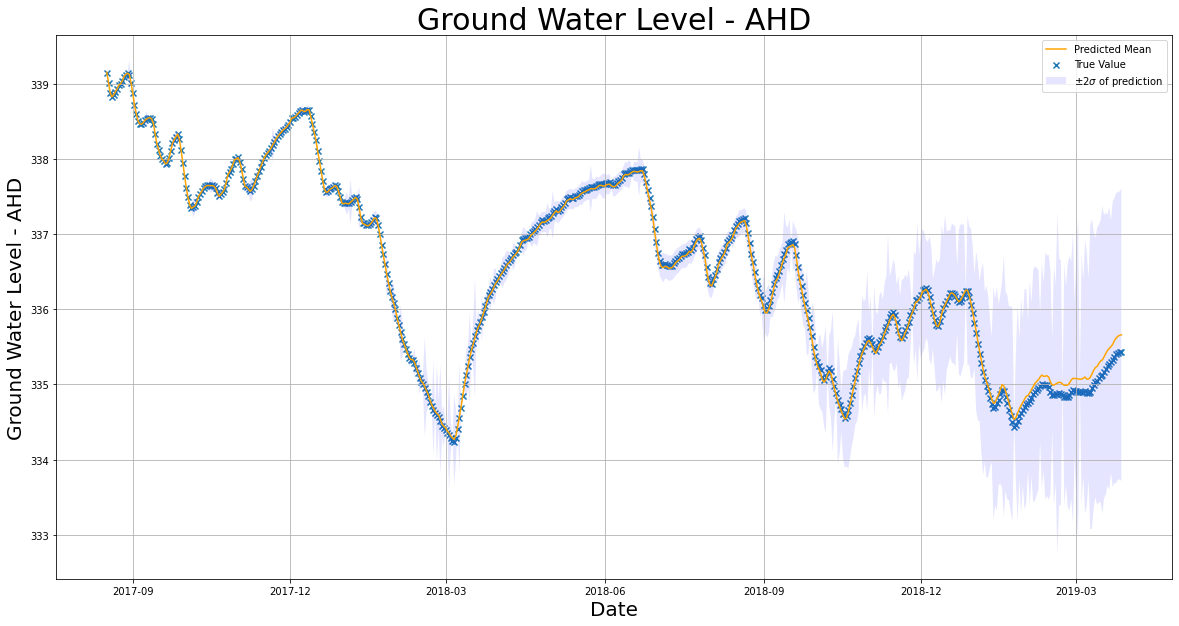

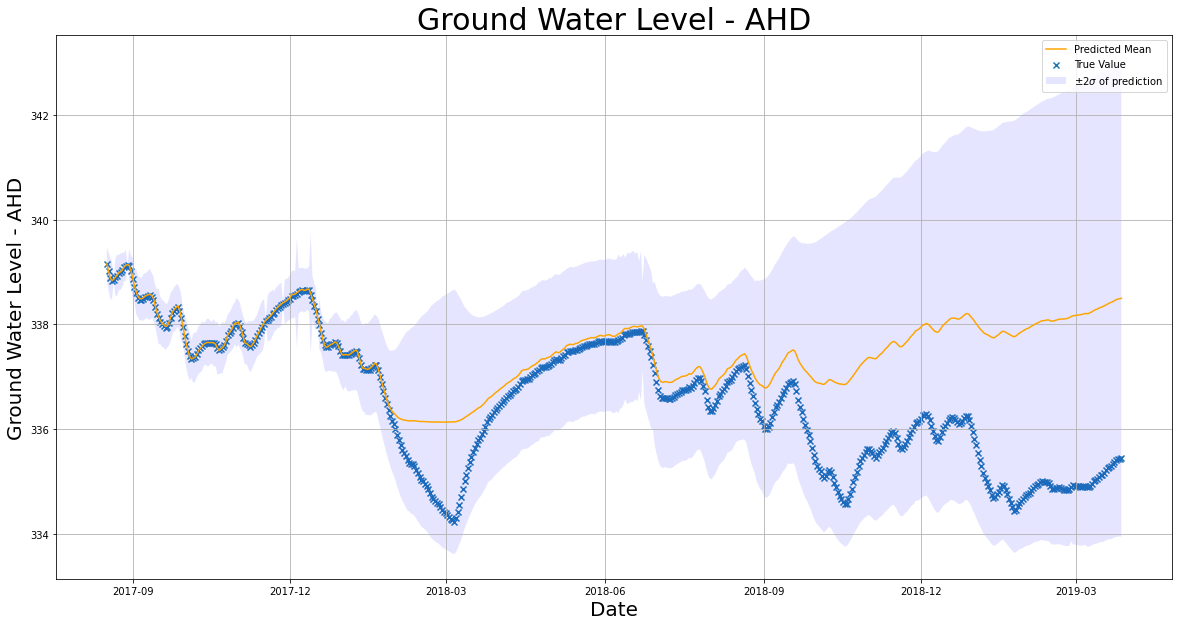

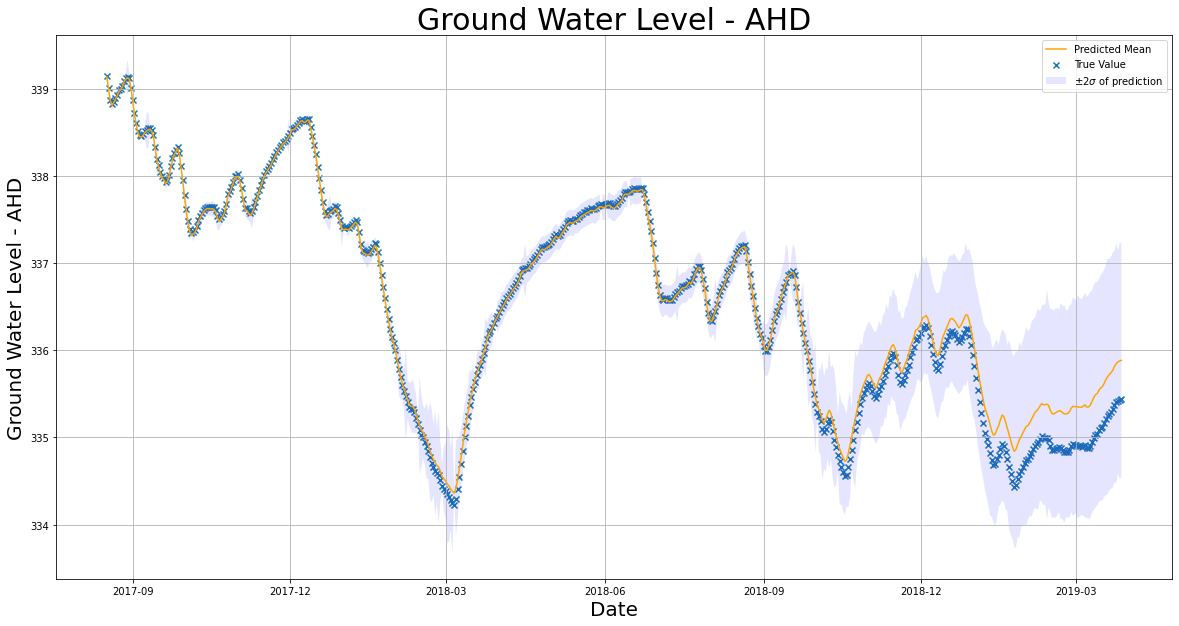

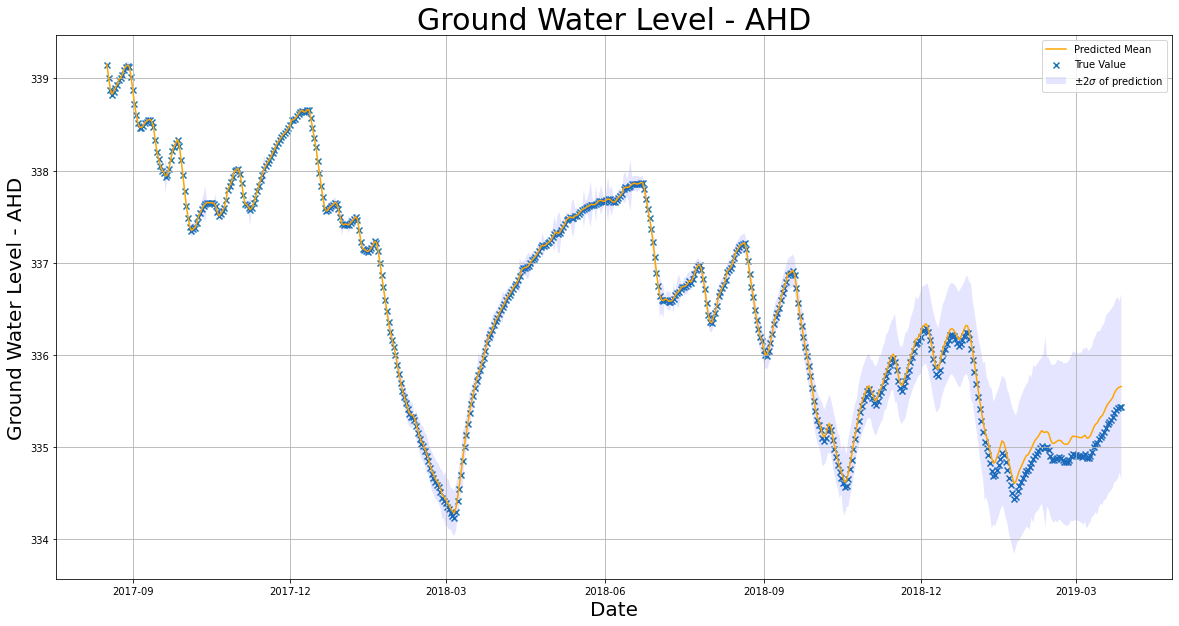

In [16]:
fm1_334_losses, fm1_334 = model_train(x_train334,y_train334,
                                      FullGP,"Squared Exponential",
                                      n_iterations=200,learning_rate=0.1)
fm1_334_mae,fm1_334_rmse = gp_model_eval(x_train334,y_train334,fm1_334)
fm1_334_best_params = gp_optimal_params(fm1_334)
f_mean_fm1_334, f_var_fm1_334, f_mean_original_fm1_334,\
f_var_original_fm1_334, y_test_original_fm1_334, \
fig_fm1_334 = gp_pred(fm1_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23,plot=True)

fm2_334_losses, fm2_334 = model_train(x_train334,y_train334,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 1/2)
fm2_334_mae,fm2_334_rmse = gp_model_eval(x_train334,y_train334,fm2_334)
fm2_334_best_params = gp_optimal_params(fm2_334)
f_mean_fm2_334, f_var_fm2_334, f_mean_original_fm2_334,\
f_var_original_fm2_334, y_test_original_fm2_334, \
fig_fm2_334 = gp_pred(fm2_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23,plot=True)

# Matern 3/2 kernel

fm3_334_losses, fm3_334 = model_train(x_train334,y_train334,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 3/2)
fm3_334_mae,fm3_334_rmse = gp_model_eval(x_train334,y_train334,fm3_334)
fm3_334_best_params = gp_optimal_params(fm3_334)
f_mean_fm3_334, f_var_fm3_334, f_mean_original_fm3_334,\
f_var_original_fm3_334, y_test_original_fm3_334, \
fig_fm3_334 = gp_pred(fm3_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23,plot=True)

# Matern 5/2 kernel

fm4_334_losses, fm4_334 = model_train(x_train334,y_train334,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 5/2)
fm4_334_mae,fm4_334_rmse = gp_model_eval(x_train334,y_train334,fm4_334)
fm4_334_best_params = gp_optimal_params(fm4_334)
f_mean_fm4_334, f_var_fm4_334, f_mean_original_fm4_334,\
f_var_original_fm4_334, y_test_original_fm4_334, \
fig_fm4_334 = gp_pred(fm4_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23,plot=True)

#### Variational approximate GP

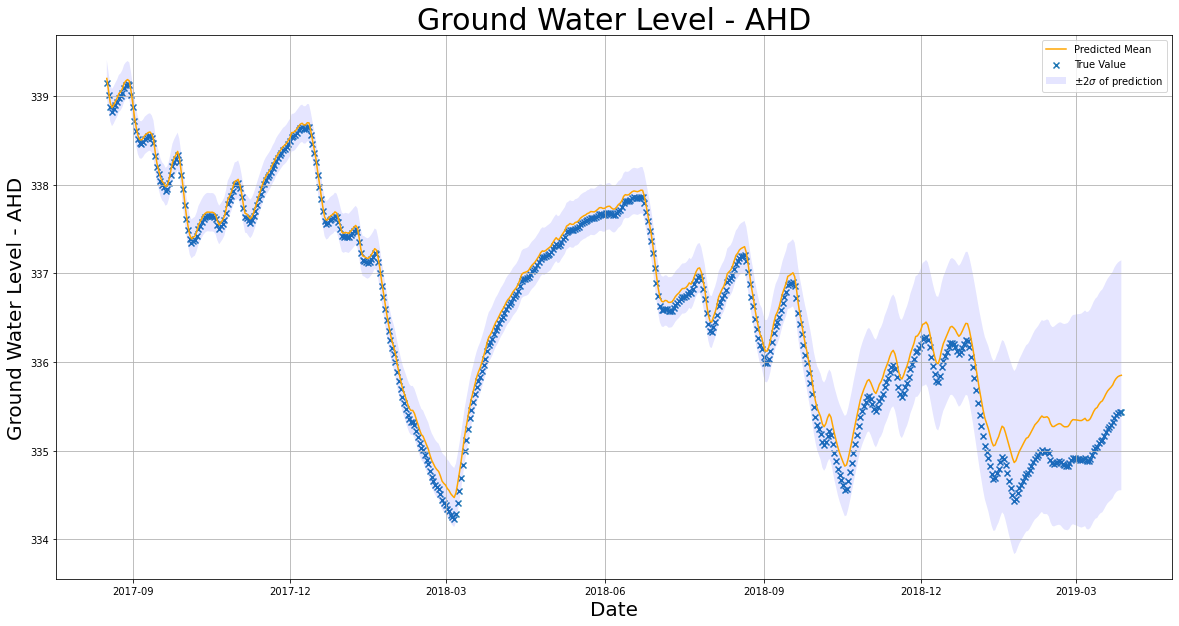

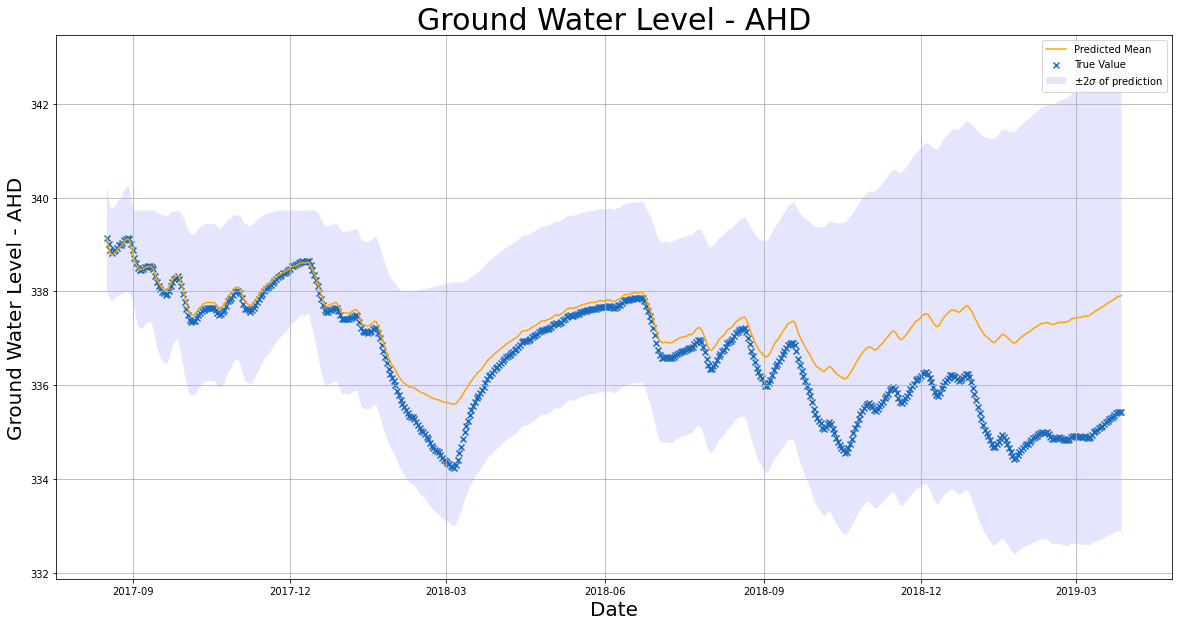

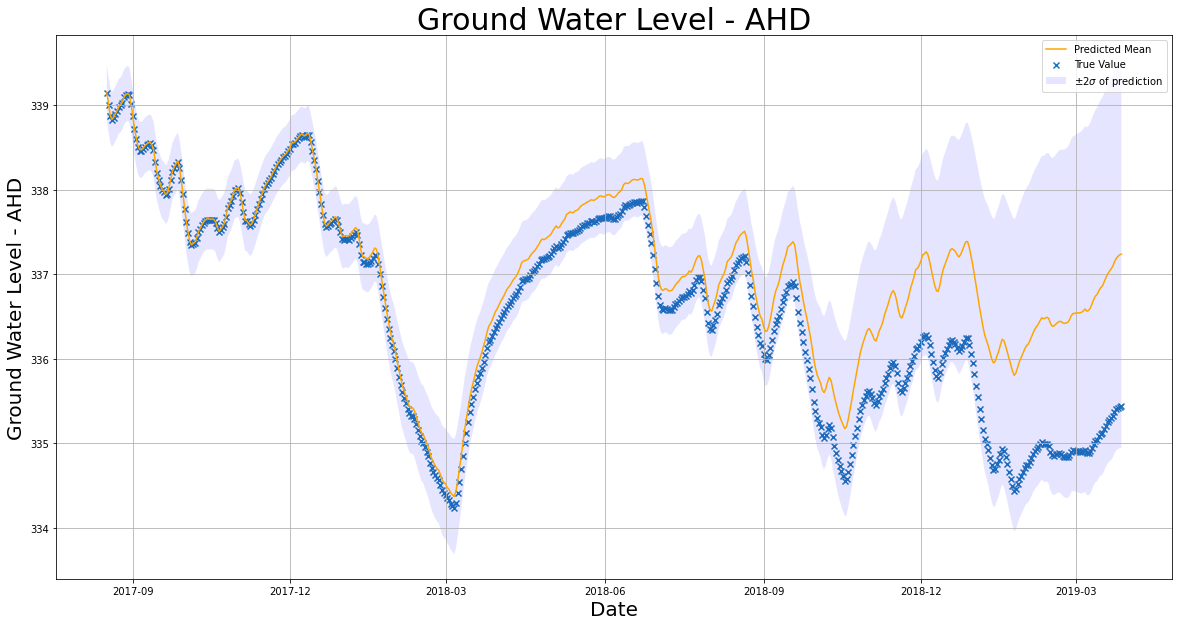

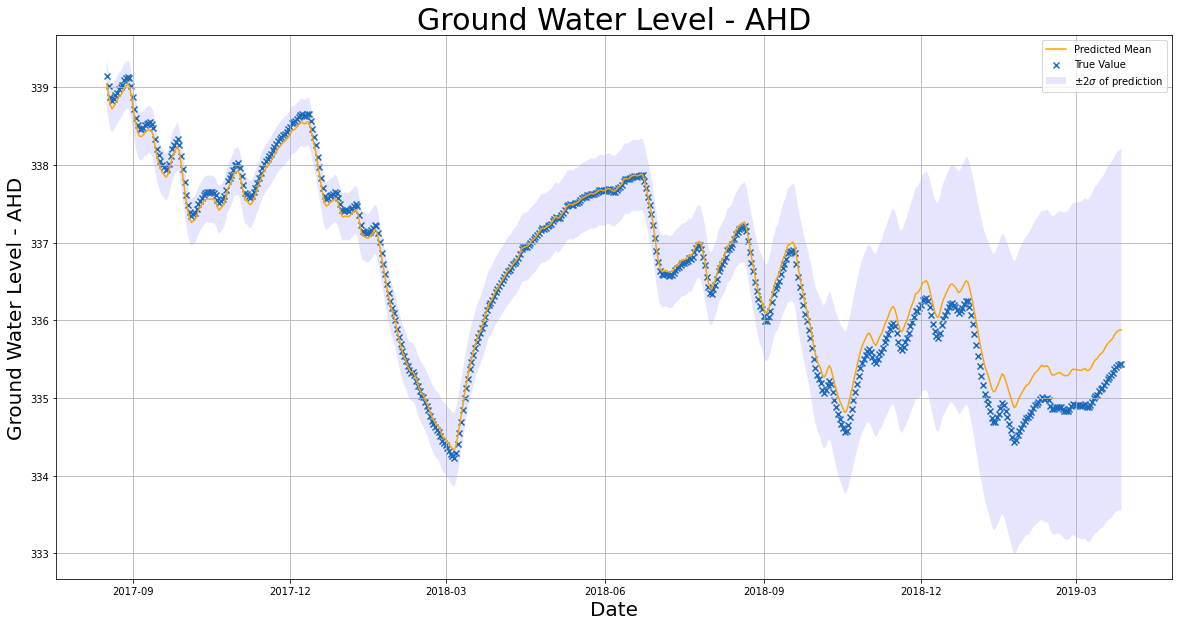

In [17]:
# RBF kernel

va1_334,va1_334_likelihood,va1_334_train_loader,va1_334_test_loader = model_train(x_train334,y_train334,
                                      GPModel,cov_function_name = "Squared Exponential",
                                      n_iterations=200,learning_rate=0.1, x_test = x_test334,
                                      y_test = y_test334,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va1_334_mae,va1_334_rmse = vagp_model_eval(va1_334_train_loader,va1_334_train_loader,
                                           va1_334,va1_334_likelihood,y_train334)
va1_334_best_params = gp_optimal_params(va1_334)

f_mean_va1_334, f_var_va1_334, f_mean_original_va1_334,\
f_var_original_va1_334, y_test_original_va1_334, \
fig_va1_334 = gp_pred(va1_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23 ,plot=True)

# Matern 1/2 kernel

va2_334,va2_334_likelihood,va2_334_train_loader,va2_334_test_loader = model_train(x_train334,y_train334,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=1/2, x_test = x_test334,
                                      y_test = y_test334,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va2_334_mae,va2_334_rmse = vagp_model_eval(va2_334_train_loader,va2_334_train_loader,
                                           va2_334,va2_334_likelihood,y_train334)
va2_334_best_params = gp_optimal_params(va2_334)
f_mean_va2_334, f_var_va2_334, f_mean_original_va2_334,\
f_var_original_va2_334, y_test_original_va2_334, \
fig_va2_334 = gp_pred(va2_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23 ,plot=True)

# Matern 3/2 kernel

va3_334,va3_334_likelihood,va3_334_train_loader,va3_334_test_loader = model_train(x_train334,y_train334,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=3/2, x_test = x_test334,
                                      y_test = y_test334,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va3_334_mae,va3_334_rmse = vagp_model_eval(va3_334_train_loader,va3_334_train_loader,
                                           va3_334,va3_334_likelihood,y_train334)
va3_334_best_params = gp_optimal_params(va2_334)
f_mean_va3_334, f_var_va3_334, f_mean_original_va3_334,\
f_var_original_va3_334, y_test_original_va3_334, \
fig_va3_334 = gp_pred(va3_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23 ,plot=True)

# Matern 5/2 kernel

va4_334,va4_334_likelihood,va4_334_train_loader,va4_334_test_loader = model_train(x_train334,y_train334,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=5/2, x_test = x_test334,
                                      y_test = y_test334,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va4_334_mae,va4_334_rmse = vagp_model_eval(va4_334_train_loader,va4_334_train_loader,
                                           va4_334,va4_334_likelihood,y_train334)
va4_334_best_params = gp_optimal_params(va4_334)
f_mean_va4_334, f_var_va4_334, f_mean_original_va4_334,\
f_var_original_va4_334, y_test_original_va4_334, \
fig_va4_334 = gp_pred(va4_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23 ,plot=True)

In [18]:
#### Metrics comparison

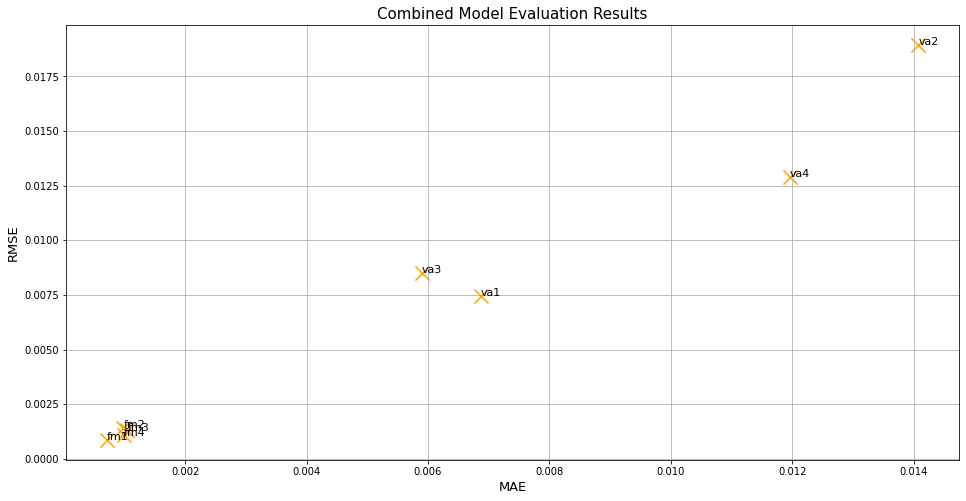

In [28]:
eval_results_334 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
              "MAE_334":[fm1_334_mae,fm2_334_mae,fm3_334_mae,fm4_334_mae,
                         va1_334_mae,va2_334_mae,va3_334_mae,va4_334_mae],
             "RMSE_334":[fm1_334_rmse,fm2_334_rmse,fm3_334_rmse,fm4_334_rmse,
                         va1_334_rmse,va2_334_rmse,va3_334_rmse,va4_334_rmse
                       ]})
eval_results_plot(eval_results_334)

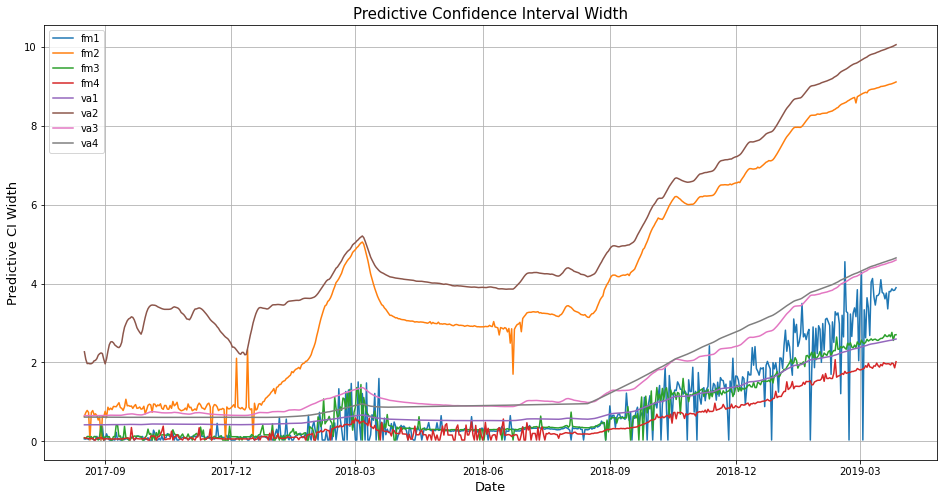

In [29]:
CIwidth_334 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
                           "CI Width":[4*np.sqrt(f_var_original_fm1_334),4*np.sqrt(f_var_original_fm2_334),
                                      4*np.sqrt(f_var_original_fm3_334),4*np.sqrt(f_var_original_fm4_334),
                                      4*np.sqrt(f_var_original_va1_334),4*np.sqrt(f_var_original_va2_334),
                                      4*np.sqrt(f_var_original_va3_334),4*np.sqrt(f_var_original_va4_334)]})
CIwidth_plot(CIwidth_334,data334,x_train334)

 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


RMSE of the test data: 0.008886952
MAE of the test data: 0.0048046196


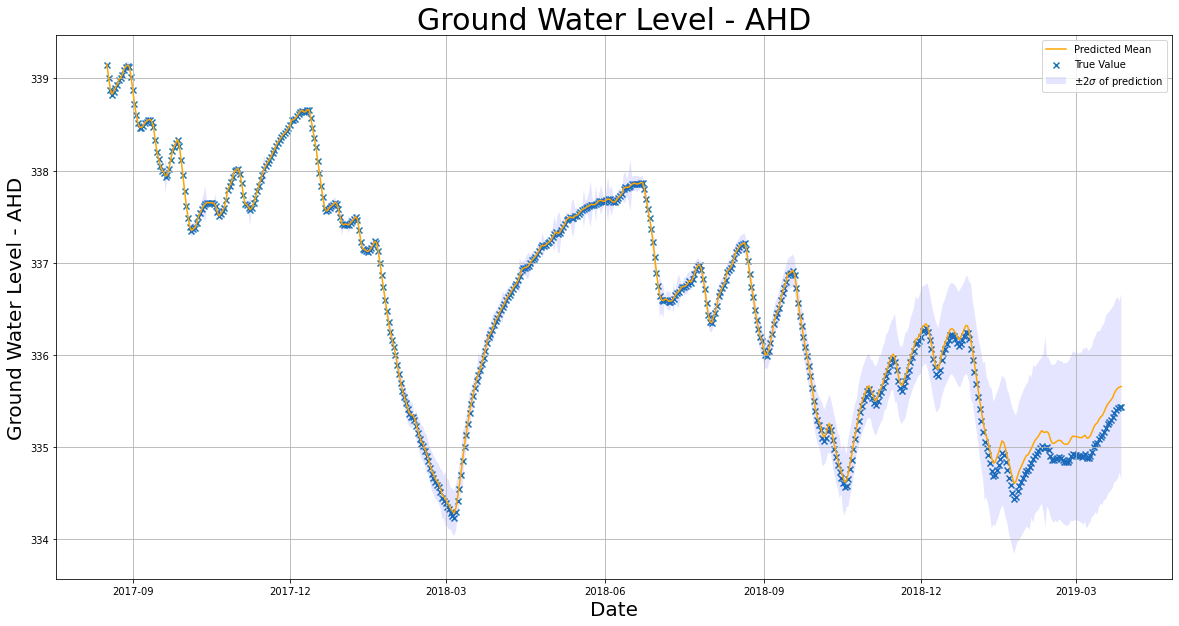

In [21]:
fig_fm4_334 = gp_pred(fm4_334,x_train334,x_test334,\
                      y_test334,data334,min_max_diff=8.102,\
                      min_ = 334.23,plot=True)
fm4_334_mae_test,fm4_334_rmse_test = gp_model_eval(x_test334,y_test334,fm4_334)
print("RMSE of the test data:", fm4_334_rmse_test)
print("MAE of the test data:", fm4_334_mae_test)

### Borehole 976

Training set contains 1371 observations.
Training set contains 588 observations.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


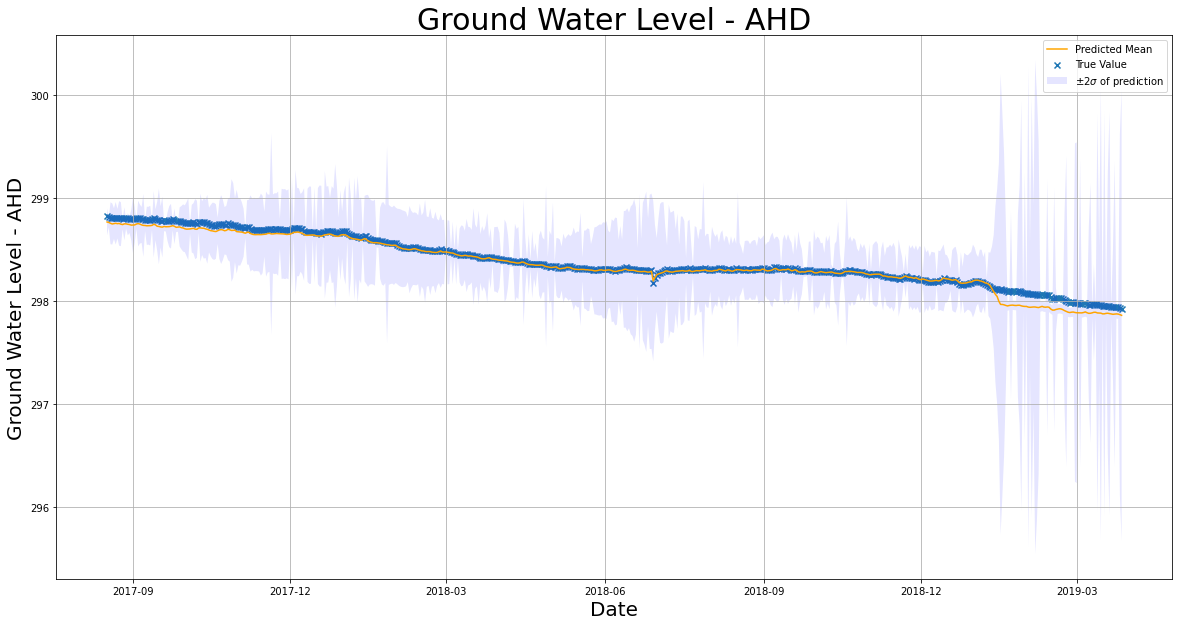

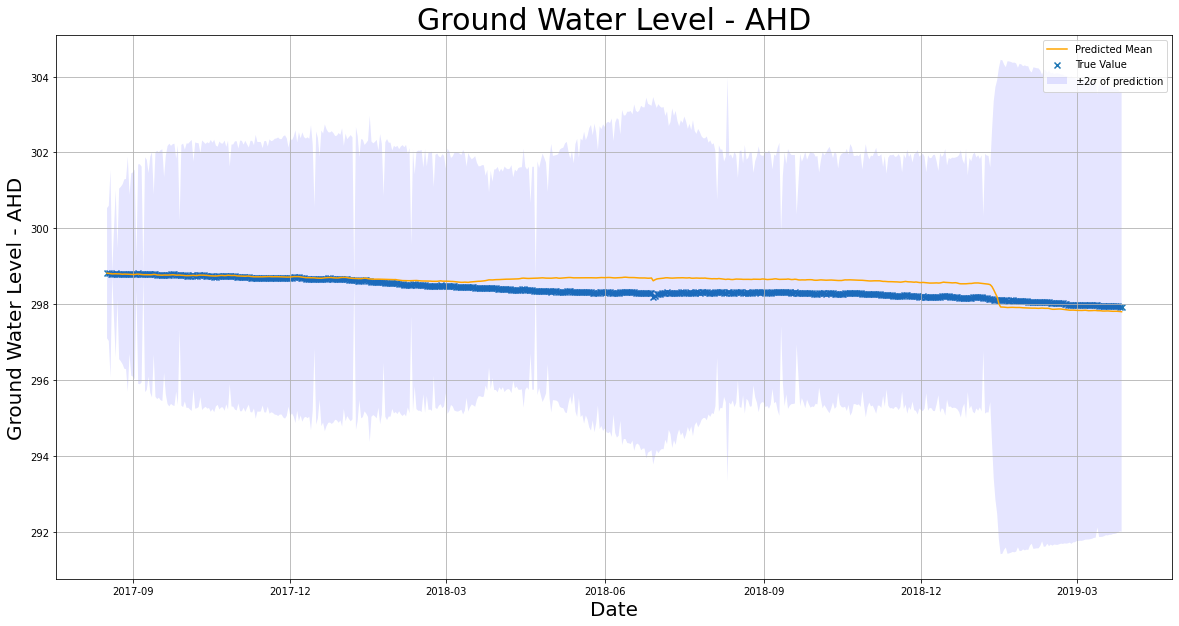

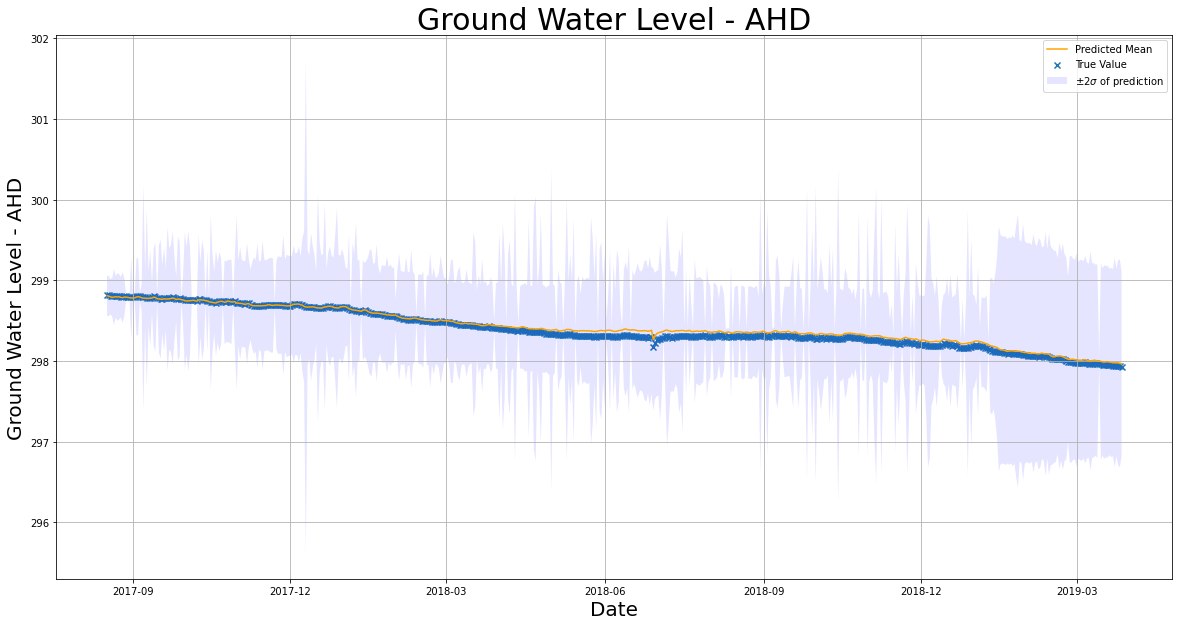

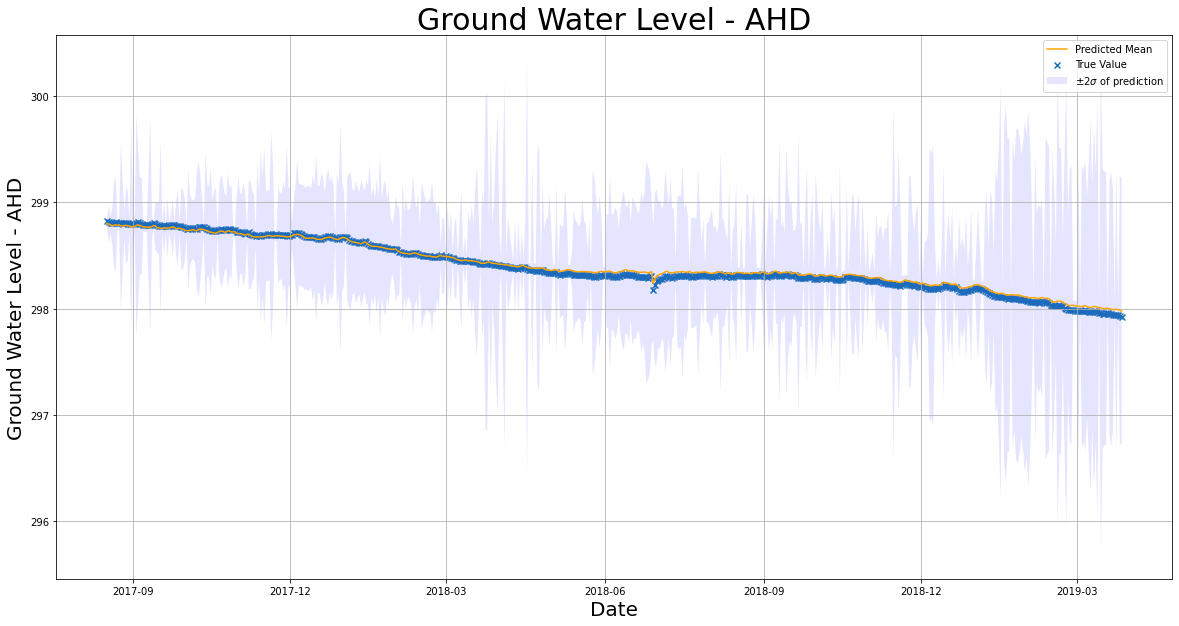

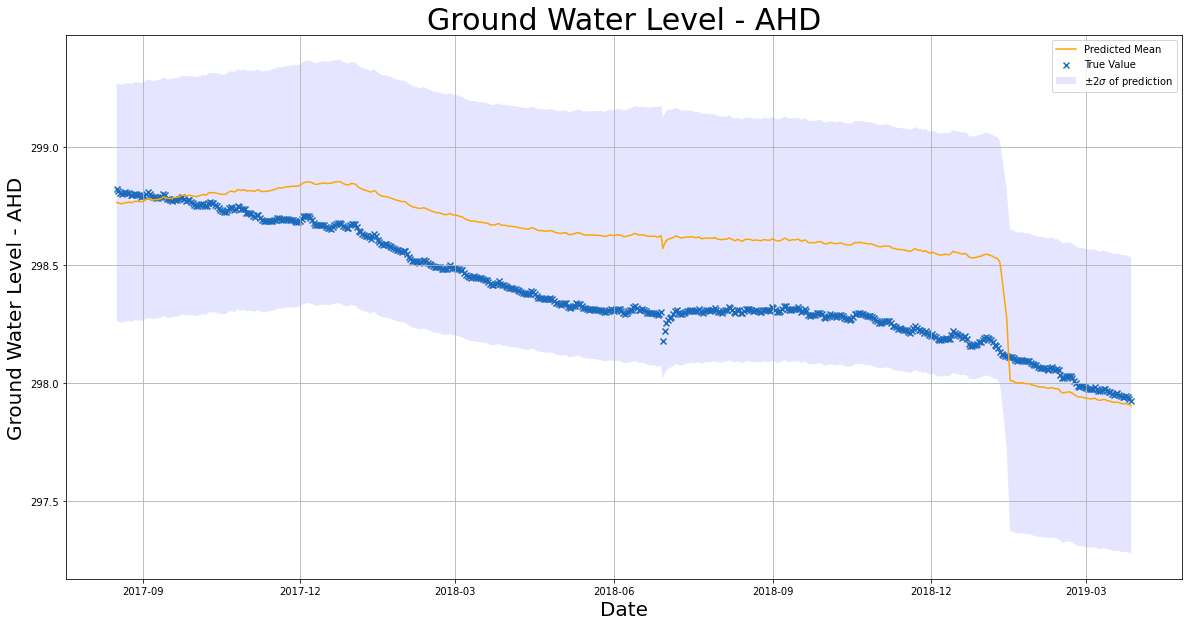

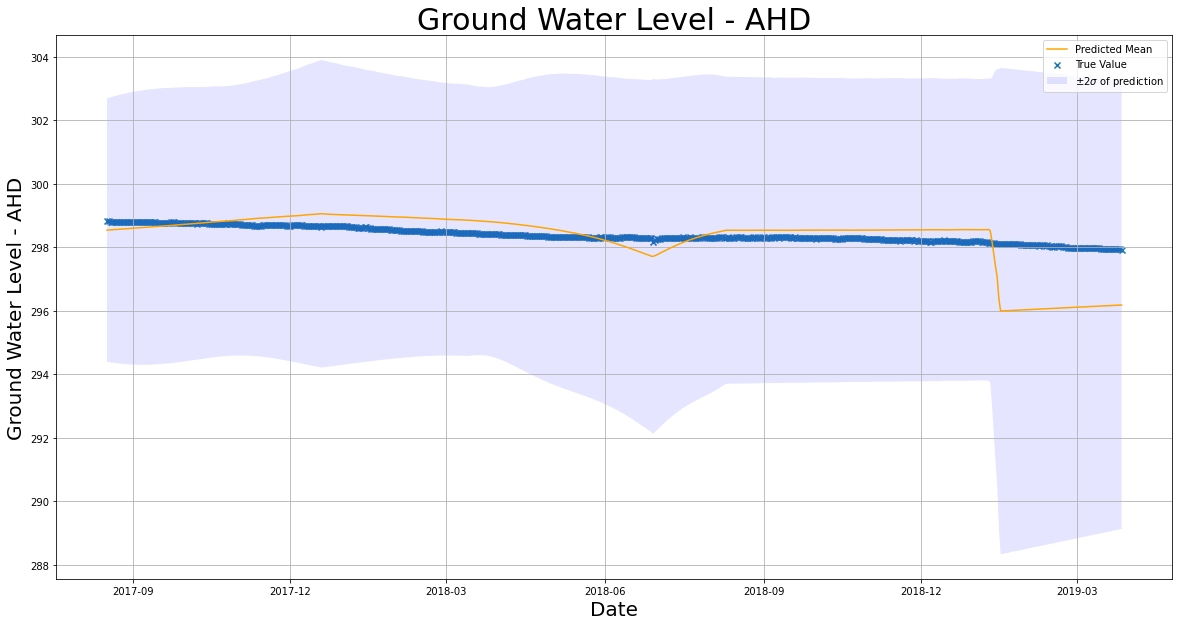

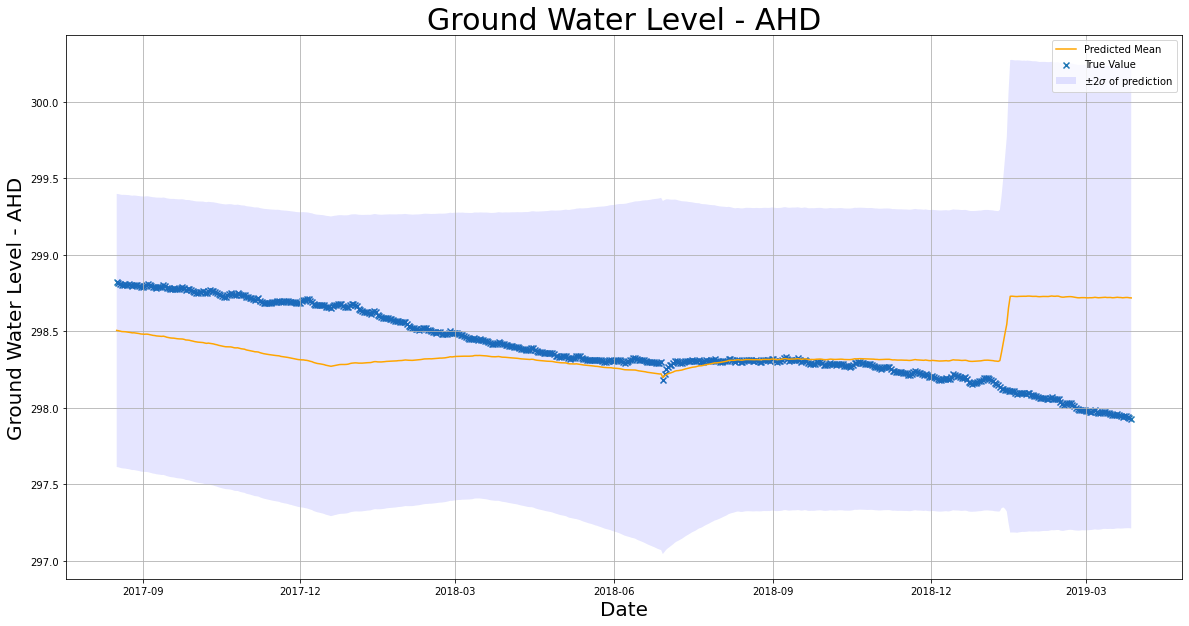

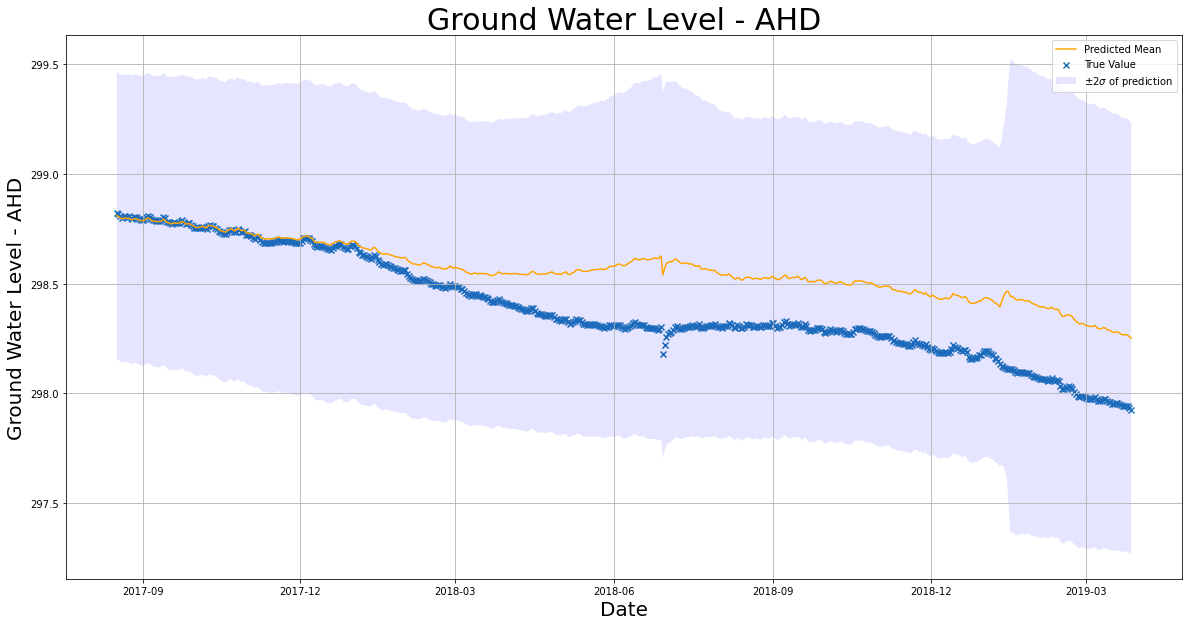

In [31]:
# split data
x_train976,x_test976,y_train976,y_test976 = data_split(data976,0.7)
print(f"Training set contains {y_train976.shape[0]} observations.")
print(f"Training set contains {y_test976.shape[0]} observations.")

# exact gp
fm1_976_losses, fm1_976 = model_train(x_train976,y_train976,
                                      FullGP,"Squared Exponential",
                                      n_iterations=200,learning_rate=0.1)
fm1_976_mae,fm1_976_rmse = gp_model_eval(x_train976,y_train976,fm1_976)
fm1_976_best_params = gp_optimal_params(fm1_976)
f_mean_fm1_976, f_var_fm1_976, f_mean_original_fm1_976,\
f_var_original_fm1_976, y_test_original_fm1_976, \
fig_fm1_976 = gp_pred(fm1_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

fm2_976_losses, fm2_976 = model_train(x_train976,y_train976,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 1/2)
fm2_976_mae,fm2_976_rmse = gp_model_eval(x_train976,y_train976,fm2_976)
fm2_976_best_params = gp_optimal_params(fm2_976)
f_mean_fm2_976, f_var_fm2_976, f_mean_original_fm2_976,\
f_var_original_fm2_976, y_test_original_fm2_976, \
fig_fm2_976 = gp_pred(fm2_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# Matern 3/2 kernel

fm3_976_losses, fm3_976 = model_train(x_train976,y_train976,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 3/2)
fm3_976_mae,fm3_976_rmse = gp_model_eval(x_train976,y_train976,fm3_976)
fm3_976_best_params = gp_optimal_params(fm3_976)
f_mean_fm3_976, f_var_fm3_976, f_mean_original_fm3_976,\
f_var_original_fm3_976, y_test_original_fm3_976, \
fig_fm3_976 = gp_pred(fm3_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# Matern 5/2 kernel

fm4_976_losses, fm4_976 = model_train(x_train976,y_train976,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 5/2)
fm4_976_mae,fm4_976_rmse = gp_model_eval(x_train976,y_train976,fm4_976)
fm4_976_best_params = gp_optimal_params(fm4_976)
f_mean_fm4_976, f_var_fm4_976, f_mean_original_fm4_976,\
f_var_original_fm4_976, y_test_original_fm4_976, \
fig_fm4_976 = gp_pred(fm4_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# variational approximate gp
# RBF kernel

va1_976,va1_976_likelihood,va1_976_train_loader,va1_976_test_loader = model_train(x_train976,y_train976,
                                      GPModel,cov_function_name = "Squared Exponential",
                                      n_iterations=200,learning_rate=0.1, x_test = x_test976,
                                      y_test = y_test976,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va1_976_mae,va1_976_rmse = vagp_model_eval(va1_976_train_loader,va1_976_train_loader,
                                           va1_976,va1_976_likelihood,y_train976)
va1_976_best_params = gp_optimal_params(va1_976)

f_mean_va1_976, f_var_va1_976, f_mean_original_va1_976,\
f_var_original_va1_976, y_test_original_va1_976, \
fig_va1_976 = gp_pred(va1_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# Matern 1/2 kernel

va2_976,va2_976_likelihood,va2_976_train_loader,va2_976_test_loader = model_train(x_train976,y_train976,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=1/2, x_test = x_test976,
                                      y_test = y_test976,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va2_976_mae,va2_976_rmse = vagp_model_eval(va2_976_train_loader,va2_976_train_loader,
                                           va2_976,va2_976_likelihood,y_train976)
va2_976_best_params = gp_optimal_params(va2_976)
f_mean_va2_976, f_var_va2_976, f_mean_original_va2_976,\
f_var_original_va2_976, y_test_original_va2_976, \
fig_va2_976 = gp_pred(va2_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# Matern 3/2 kernel

va3_976,va3_976_likelihood,va3_976_train_loader,va3_976_test_loader = model_train(x_train976,y_train976,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=3/2, x_test = x_test976,
                                      y_test = y_test976,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va3_976_mae,va3_976_rmse = vagp_model_eval(va3_976_train_loader,va3_976_train_loader,
                                           va3_976,va3_976_likelihood,y_train976)
va3_976_best_params = gp_optimal_params(va2_976)
f_mean_va3_976, f_var_va3_976, f_mean_original_va3_976,\
f_var_original_va3_976, y_test_original_va3_976, \
fig_va3_976 = gp_pred(va3_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

# Matern 5/2 kernel

va4_976,va4_976_likelihood,va4_976_train_loader,va4_976_test_loader = model_train(x_train976,y_train976,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=5/2, x_test = x_test976,
                                      y_test = y_test976,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va4_976_mae,va4_976_rmse = vagp_model_eval(va4_976_train_loader,va4_976_train_loader,
                                           va4_976,va4_976_likelihood,y_train976)
va4_976_best_params = gp_optimal_params(va4_976)
f_mean_va4_976, f_var_va4_976, f_mean_original_va4_976,\
f_var_original_va4_976, y_test_original_va4_976, \
fig_va4_976 = gp_pred(va4_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)

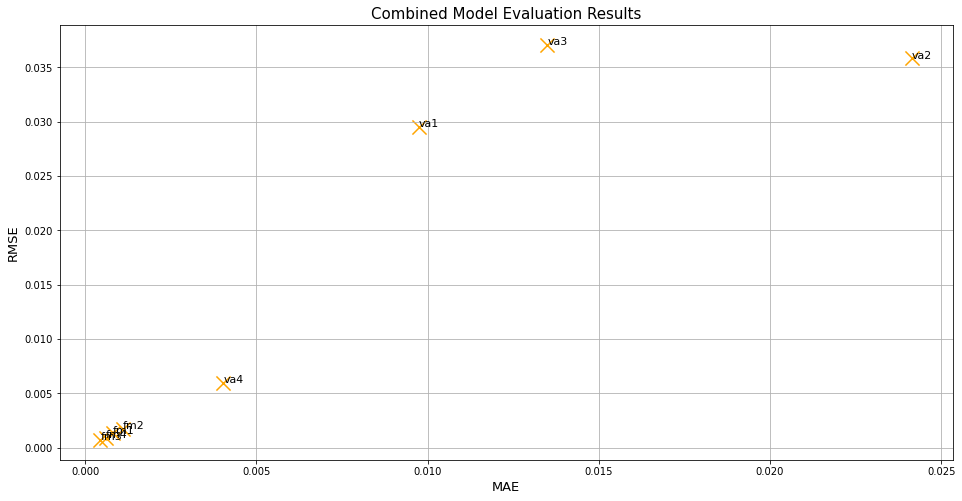

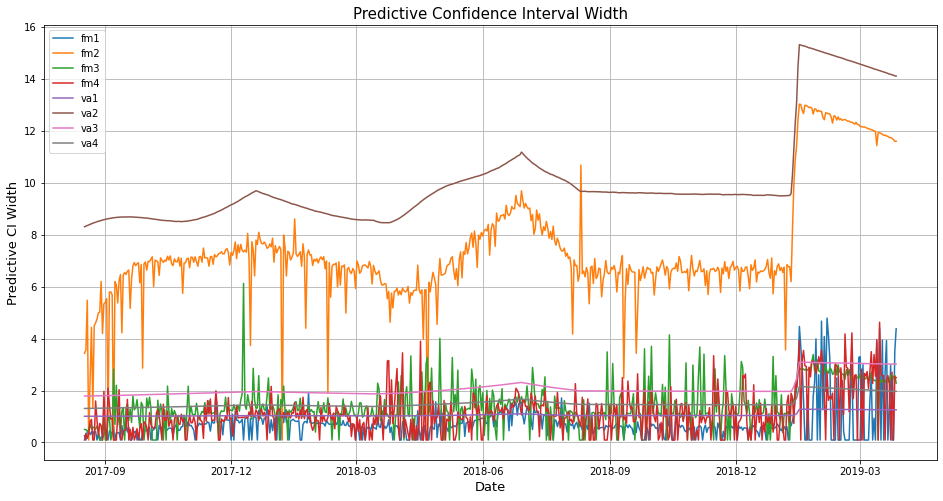

In [32]:
# metrics comparison
eval_results_976 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
              "MAE_976":[fm1_976_mae,fm2_976_mae,fm3_976_mae,fm4_976_mae,
                         va1_976_mae,va2_976_mae,va3_976_mae,va4_976_mae],
             "RMSE_976":[fm1_976_rmse,fm2_976_rmse,fm3_976_rmse,fm4_976_rmse,
                         va1_976_rmse,va2_976_rmse,va3_976_rmse,va4_976_rmse
                       ]})
eval_results_plot(eval_results_976)

# CI width
CIwidth_976 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
                           "CI Width":[4*np.sqrt(f_var_original_fm1_976),4*np.sqrt(f_var_original_fm2_976),
                                      4*np.sqrt(f_var_original_fm3_976),4*np.sqrt(f_var_original_fm4_976),
                                      4*np.sqrt(f_var_original_va1_976),4*np.sqrt(f_var_original_va2_976),
                                      4*np.sqrt(f_var_original_va3_976),4*np.sqrt(f_var_original_va4_976)]})
CIwidth_plot(CIwidth_976,data976,x_train976)



 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


RMSE of the test data: 0.0011880598
MAE of the test data: 0.0010499011


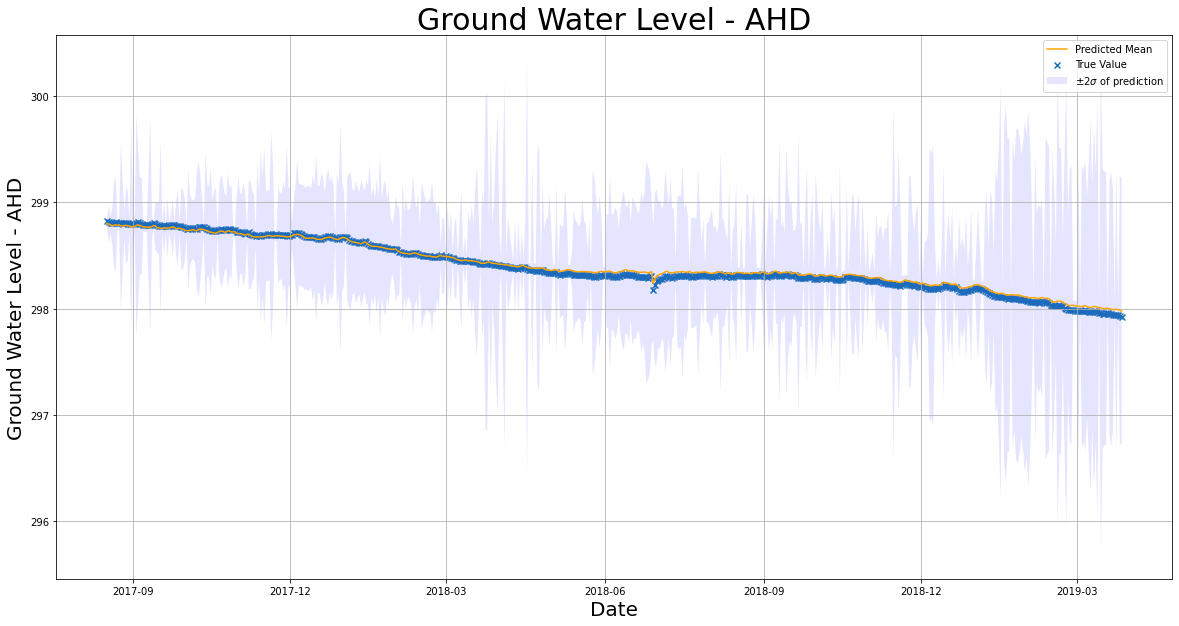

In [34]:
# choose fm4 according to all conditions
fig_fm4_976 = gp_pred(fm4_976,x_train976,x_test976,\
                      y_test976,data976,min_max_diff=23.135,\
                      min_ = 276.335,plot=True)
fm4_976_mae_test,fm4_976_rmse_test = gp_model_eval(x_test976,y_test976,fm4_976)
print("RMSE of the test data:", fm4_976_rmse_test)
print("MAE of the test data:", fm4_976_mae_test)

### Borehole 067

Training set contains 974 observations.
Training set contains 418 observations.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


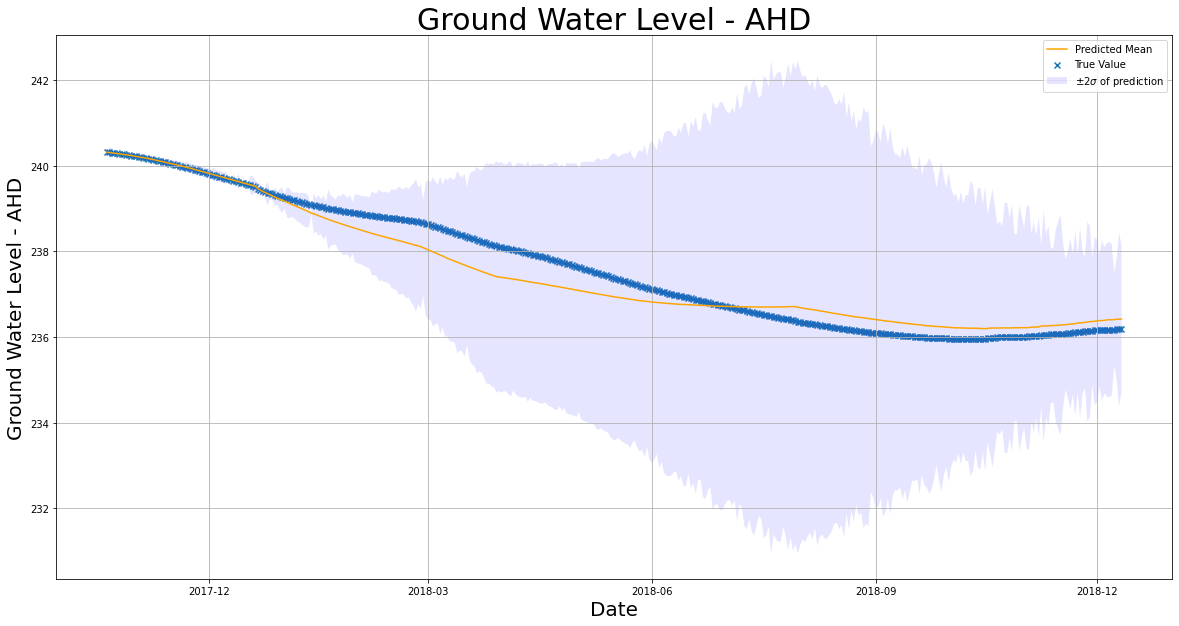

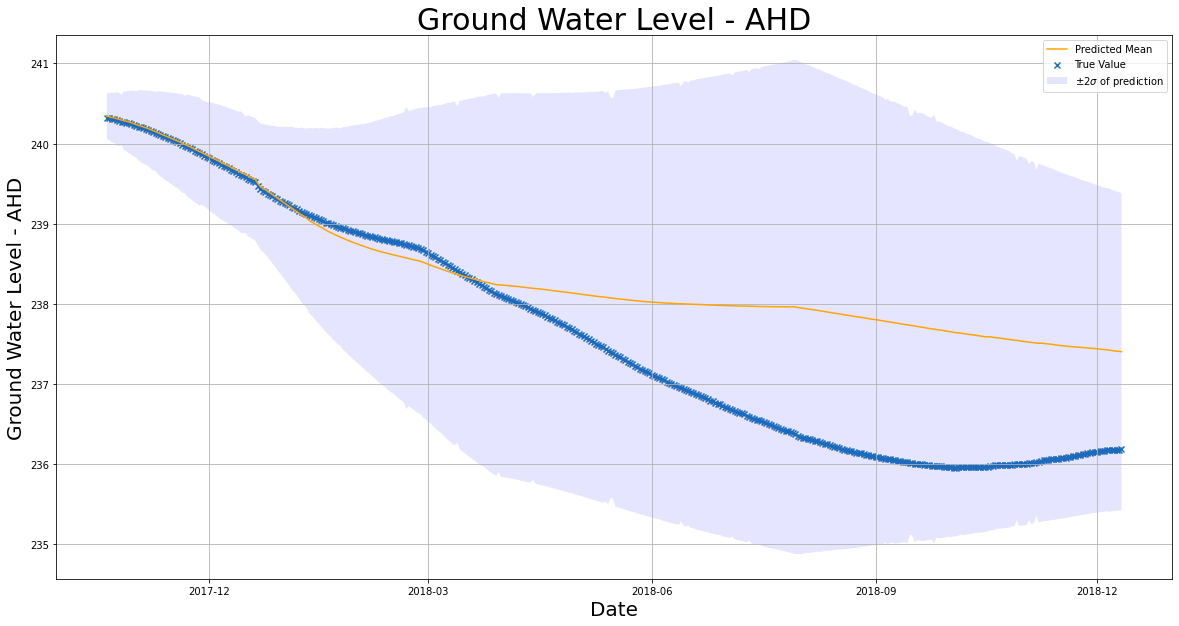

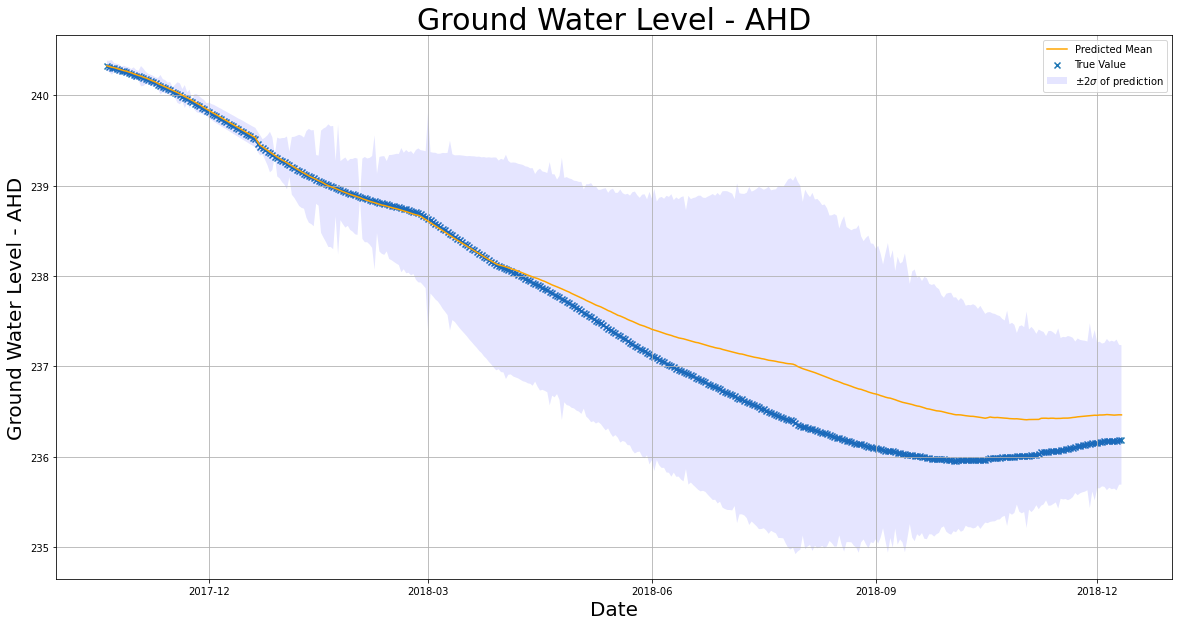

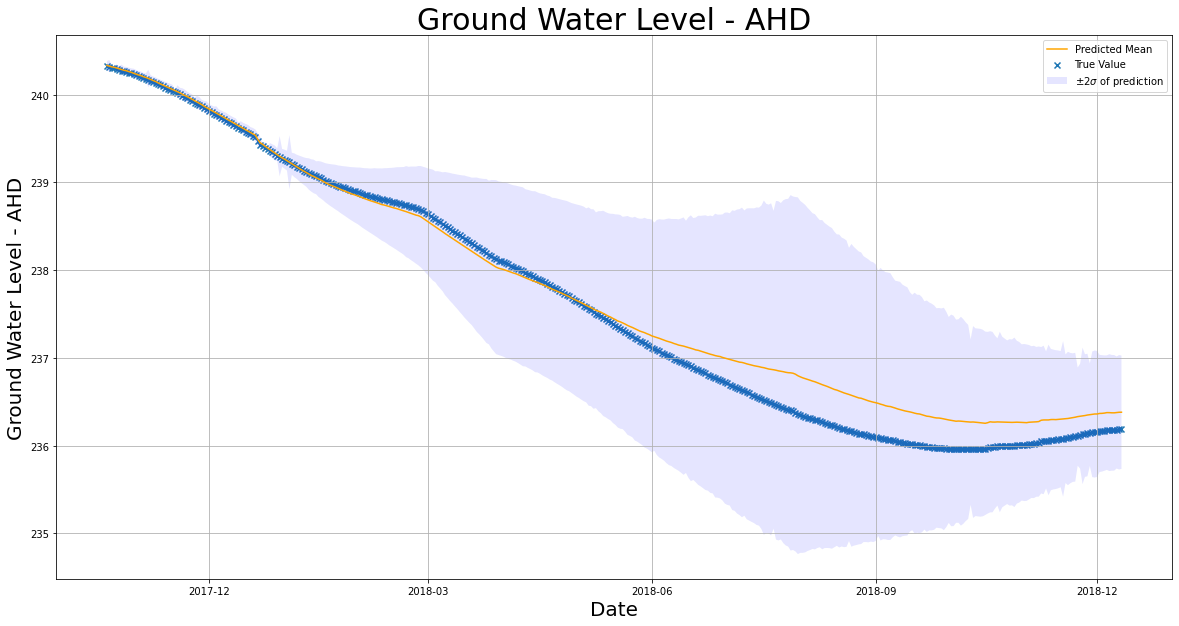

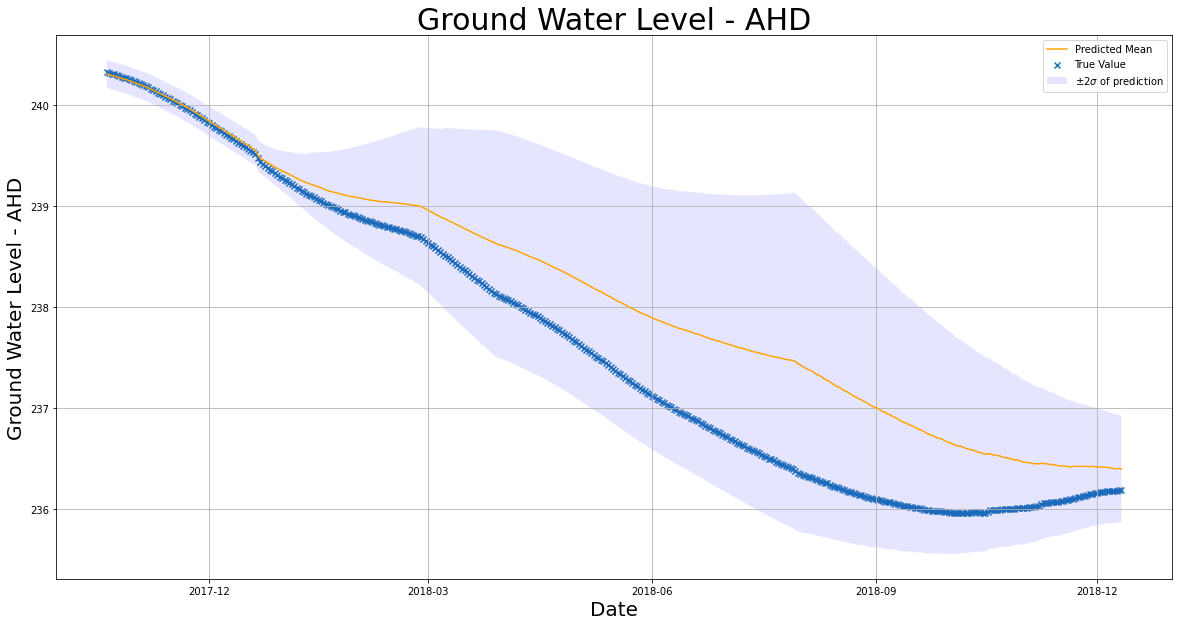

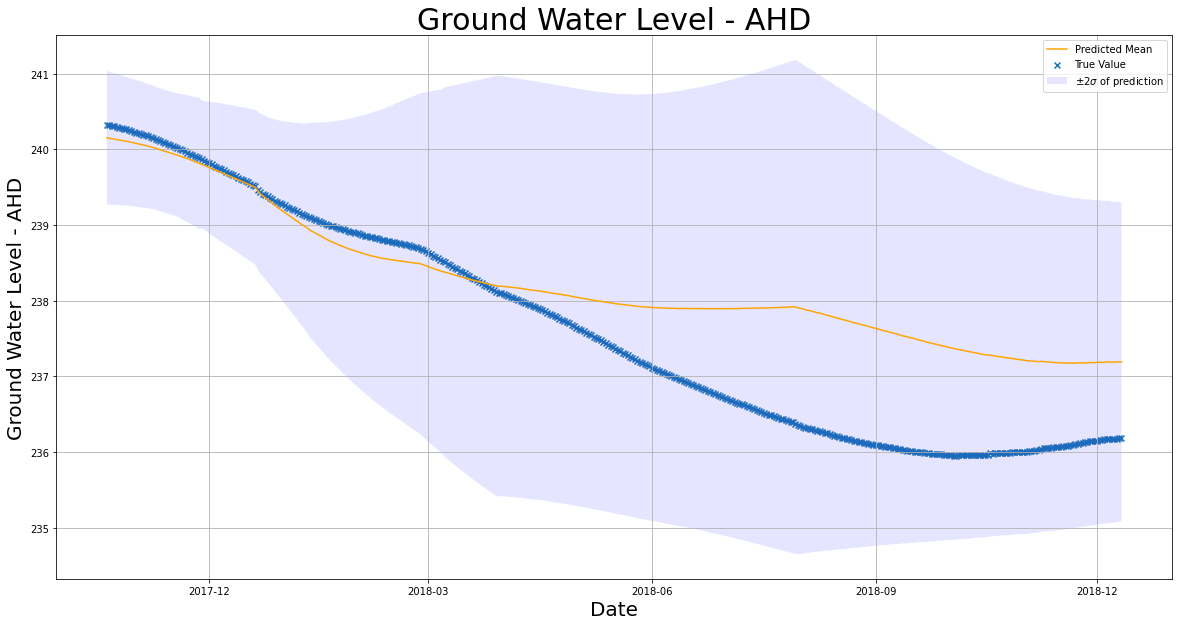

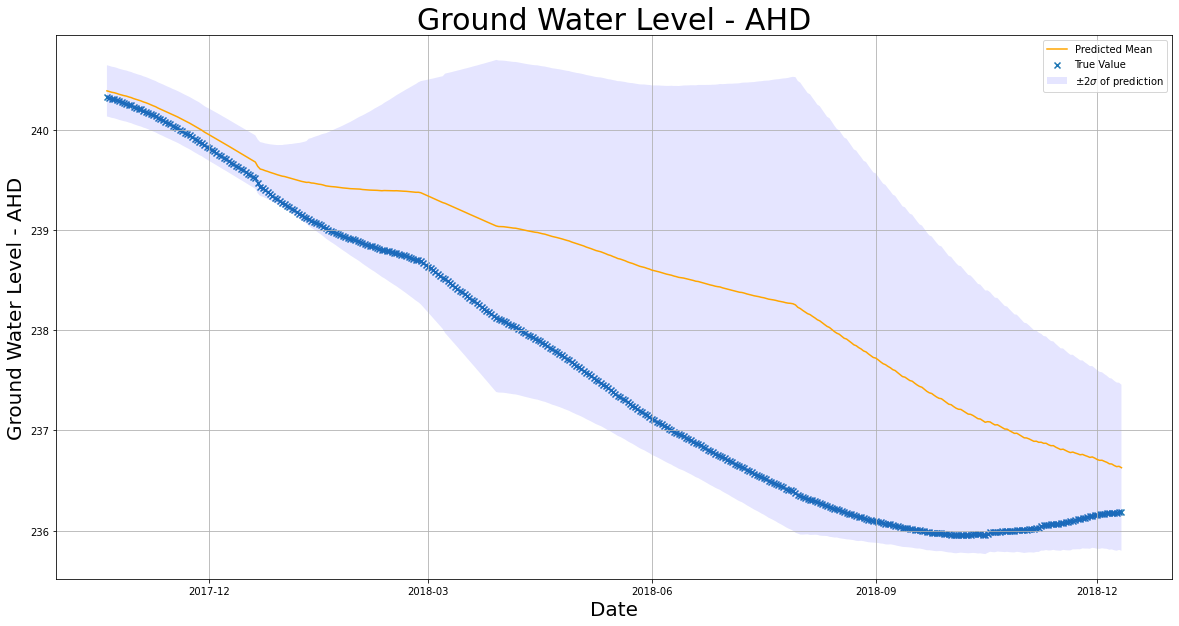

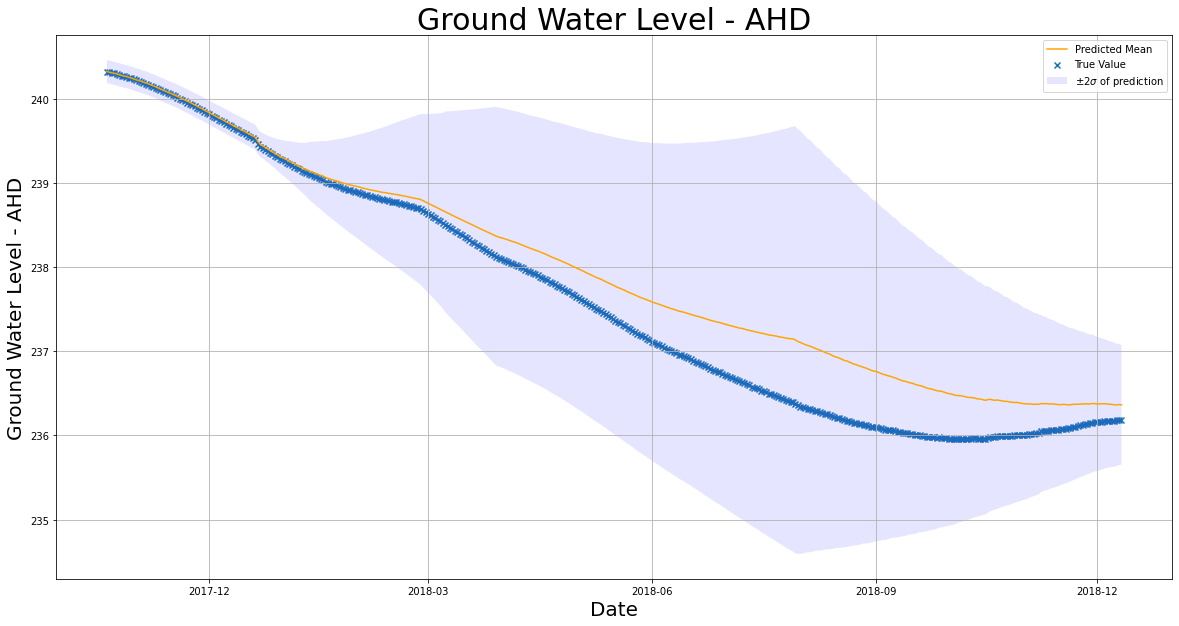

In [35]:
# split data
x_train067,x_test067,y_train067,y_test067 = data_split(data067,0.7)
print(f"Training set contains {y_train067.shape[0]} observations.")
print(f"Training set contains {y_test067.shape[0]} observations.")

# exact gp
fm1_067_losses, fm1_067 = model_train(x_train067,y_train067,
                                      FullGP,"Squared Exponential",
                                      n_iterations=200,learning_rate=0.1)
fm1_067_mae,fm1_067_rmse = gp_model_eval(x_train067,y_train067,fm1_067)
fm1_067_best_params = gp_optimal_params(fm1_067)
f_mean_fm1_067, f_var_fm1_067, f_mean_original_fm1_067,\
f_var_original_fm1_067, y_test_original_fm1_067, \
fig_fm1_067 = gp_pred(fm1_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

fm2_067_losses, fm2_067 = model_train(x_train067,y_train067,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 1/2)
fm2_067_mae,fm2_067_rmse = gp_model_eval(x_train067,y_train067,fm2_067)
fm2_067_best_params = gp_optimal_params(fm2_067)
f_mean_fm2_067, f_var_fm2_067, f_mean_original_fm2_067,\
f_var_original_fm2_067, y_test_original_fm2_067, \
fig_fm2_067 = gp_pred(fm2_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# Matern 3/2 kernel

fm3_067_losses, fm3_067 = model_train(x_train067,y_train067,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 3/2)
fm3_067_mae,fm3_067_rmse = gp_model_eval(x_train067,y_train067,fm3_067)
fm3_067_best_params = gp_optimal_params(fm3_067)
f_mean_fm3_067, f_var_fm3_067, f_mean_original_fm3_067,\
f_var_original_fm3_067, y_test_original_fm3_067, \
fig_fm3_067 = gp_pred(fm3_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# Matern 5/2 kernel

fm4_067_losses, fm4_067 = model_train(x_train067,y_train067,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 5/2)
fm4_067_mae,fm4_067_rmse = gp_model_eval(x_train067,y_train067,fm4_067)
fm4_067_best_params = gp_optimal_params(fm4_067)
f_mean_fm4_067, f_var_fm4_067, f_mean_original_fm4_067,\
f_var_original_fm4_067, y_test_original_fm4_067, \
fig_fm4_067 = gp_pred(fm4_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# variational approximate gp
# RBF kernel

va1_067,va1_067_likelihood,va1_067_train_loader,va1_067_test_loader = model_train(x_train067,y_train067,
                                      GPModel,cov_function_name = "Squared Exponential",
                                      n_iterations=200,learning_rate=0.1, x_test = x_test067,
                                      y_test = y_test067,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va1_067_mae,va1_067_rmse = vagp_model_eval(va1_067_train_loader,va1_067_train_loader,
                                           va1_067,va1_067_likelihood,y_train067)
va1_067_best_params = gp_optimal_params(va1_067)

f_mean_va1_067, f_var_va1_067, f_mean_original_va1_067,\
f_var_original_va1_067, y_test_original_va1_067, \
fig_va1_067 = gp_pred(va1_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# Matern 1/2 kernel

va2_067,va2_067_likelihood,va2_067_train_loader,va2_067_test_loader = model_train(x_train067,y_train067,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=1/2, x_test = x_test067,
                                      y_test = y_test067,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va2_067_mae,va2_067_rmse = vagp_model_eval(va2_067_train_loader,va2_067_train_loader,
                                           va2_067,va2_067_likelihood,y_train067)
va2_067_best_params = gp_optimal_params(va2_067)
f_mean_va2_067, f_var_va2_067, f_mean_original_va2_067,\
f_var_original_va2_067, y_test_original_va2_067, \
fig_va2_067 = gp_pred(va2_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# Matern 3/2 kernel

va3_067,va3_067_likelihood,va3_067_train_loader,va3_067_test_loader = model_train(x_train067,y_train067,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=3/2, x_test = x_test067,
                                      y_test = y_test067,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va3_067_mae,va3_067_rmse = vagp_model_eval(va3_067_train_loader,va3_067_train_loader,
                                           va3_067,va3_067_likelihood,y_train067)
va3_067_best_params = gp_optimal_params(va2_067)
f_mean_va3_067, f_var_va3_067, f_mean_original_va3_067,\
f_var_original_va3_067, y_test_original_va3_067, \
fig_va3_067 = gp_pred(va3_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

# Matern 5/2 kernel

va4_067,va4_067_likelihood,va4_067_train_loader,va4_067_test_loader = model_train(x_train067,y_train067,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=5/2, x_test = x_test067,
                                      y_test = y_test067,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va4_067_mae,va4_067_rmse = vagp_model_eval(va4_067_train_loader,va4_067_train_loader,
                                           va4_067,va4_067_likelihood,y_train067)
va4_067_best_params = gp_optimal_params(va4_067)
f_mean_va4_067, f_var_va4_067, f_mean_original_va4_067,\
f_var_original_va4_067, y_test_original_va4_067, \
fig_va4_067 = gp_pred(va4_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.955,plot=True)

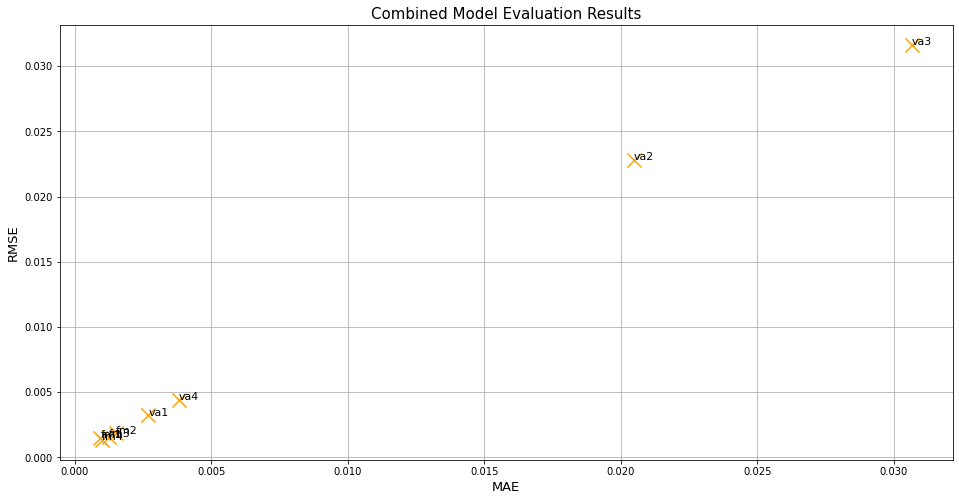

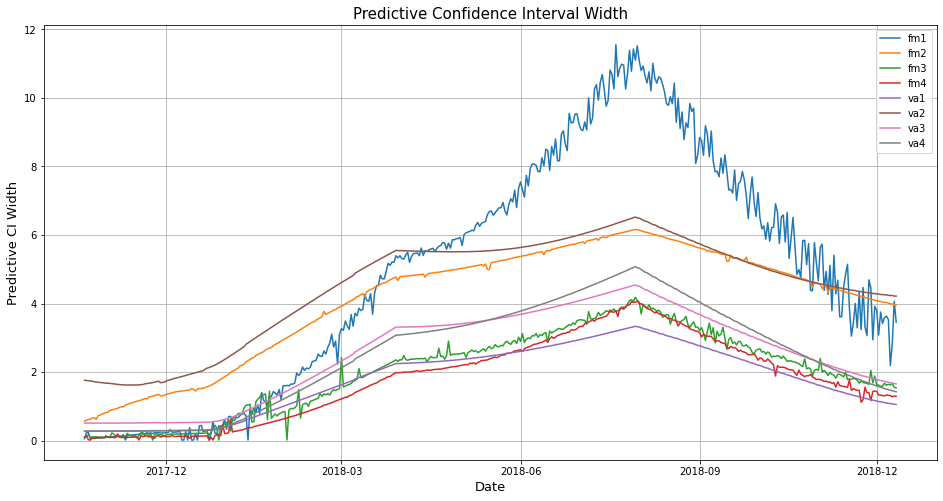

In [36]:
# metrics comparison
eval_results_067 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
              "MAE_067":[fm1_067_mae,fm2_067_mae,fm3_067_mae,fm4_067_mae,
                         va1_067_mae,va2_067_mae,va3_067_mae,va4_067_mae],
             "RMSE_067":[fm1_067_rmse,fm2_067_rmse,fm3_067_rmse,fm4_067_rmse,
                         va1_067_rmse,va2_067_rmse,va3_067_rmse,va4_067_rmse
                       ]})
eval_results_plot(eval_results_067)

# CI width
CIwidth_067 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
                           "CI Width":[4*np.sqrt(f_var_original_fm1_067),4*np.sqrt(f_var_original_fm2_067),
                                      4*np.sqrt(f_var_original_fm3_067),4*np.sqrt(f_var_original_fm4_067),
                                      4*np.sqrt(f_var_original_va1_067),4*np.sqrt(f_var_original_va2_067),
                                      4*np.sqrt(f_var_original_va3_067),4*np.sqrt(f_var_original_va4_067)]})
CIwidth_plot(CIwidth_067,data067,x_train067)



 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


RMSE of the test data: 0.049392927
MAE of the test data: 0.0371514


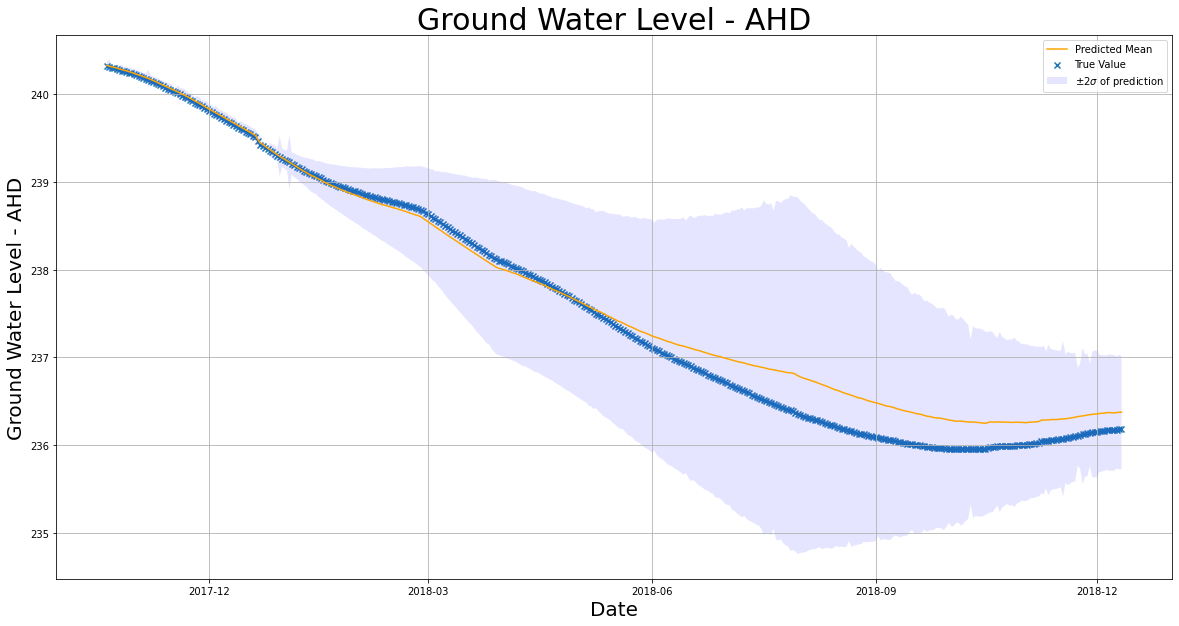

In [37]:
# choose fm4 according to all conditions
fig_fm4_067 = gp_pred(fm4_067,x_train067,x_test067,\
                      y_test067,data067,min_max_diff=4.436,\
                      min_ = 235.95,plot=True)
fm4_067_mae_test,fm4_067_rmse_test = gp_model_eval(x_test067,y_test067,fm4_067)
print("RMSE of the test data:", fm4_067_rmse_test)
print("MAE of the test data:", fm4_067_mae_test)

### Borehole 569

Training set contains 1357 observations.
Training set contains 582 observations.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning:The input matches the stored training data. Did you forget to call model.train()?
 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


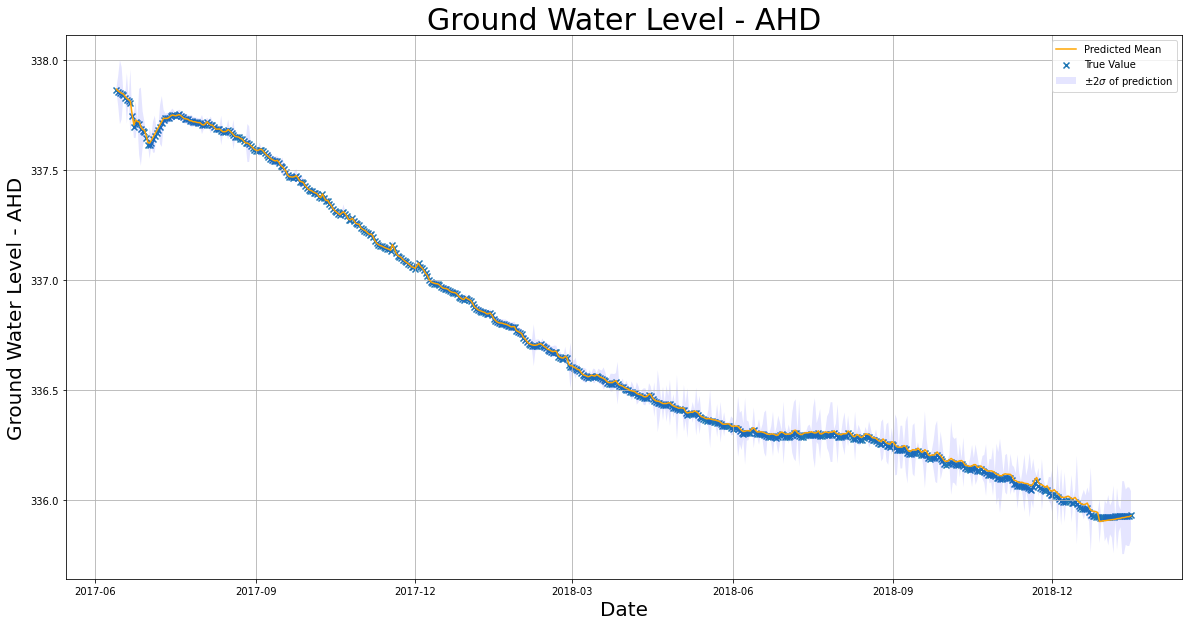

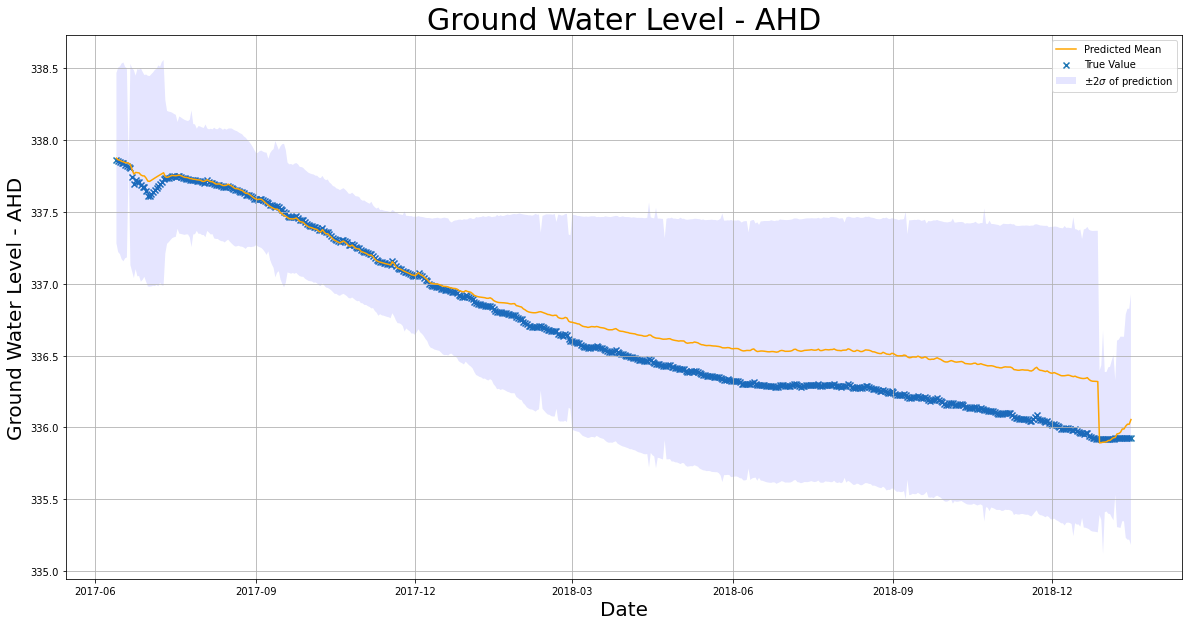

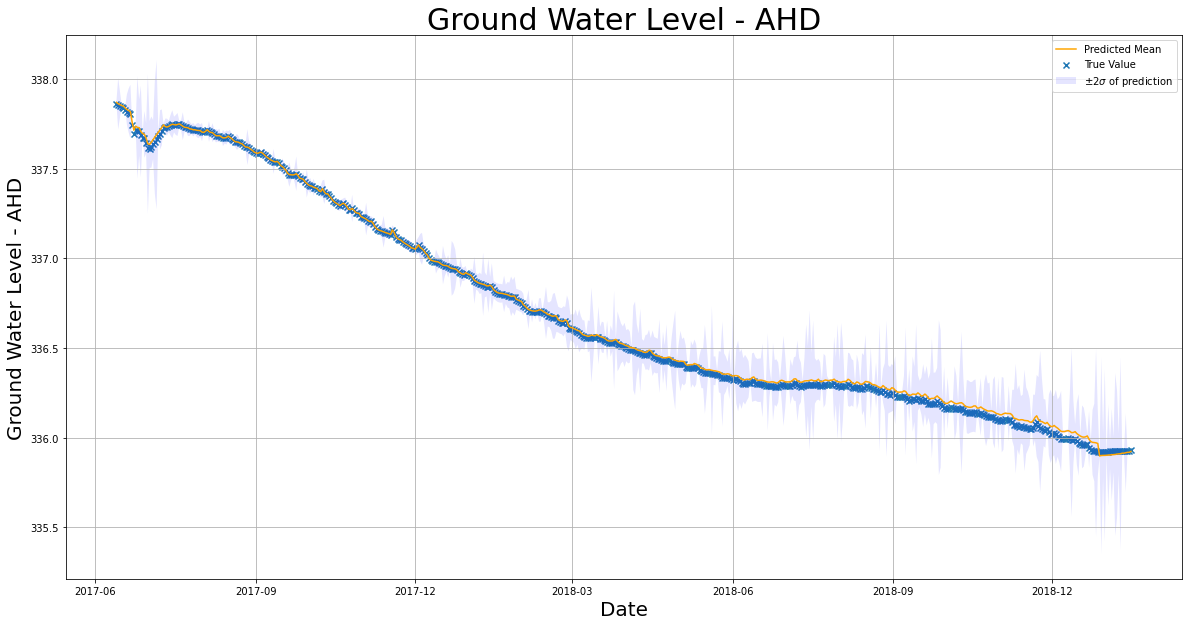

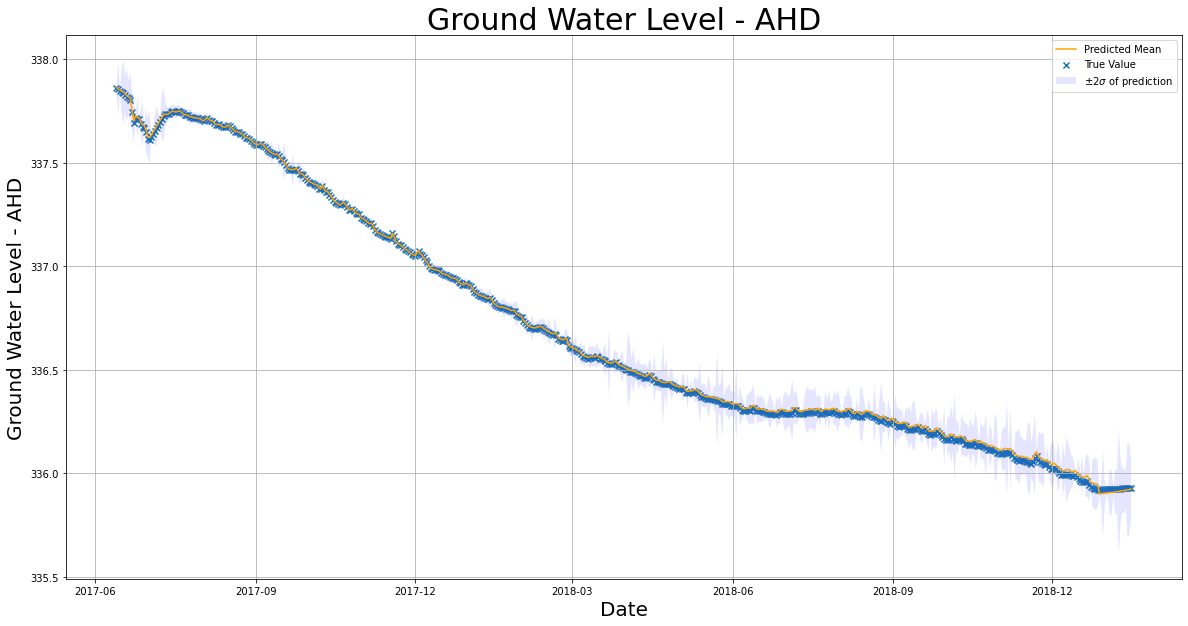

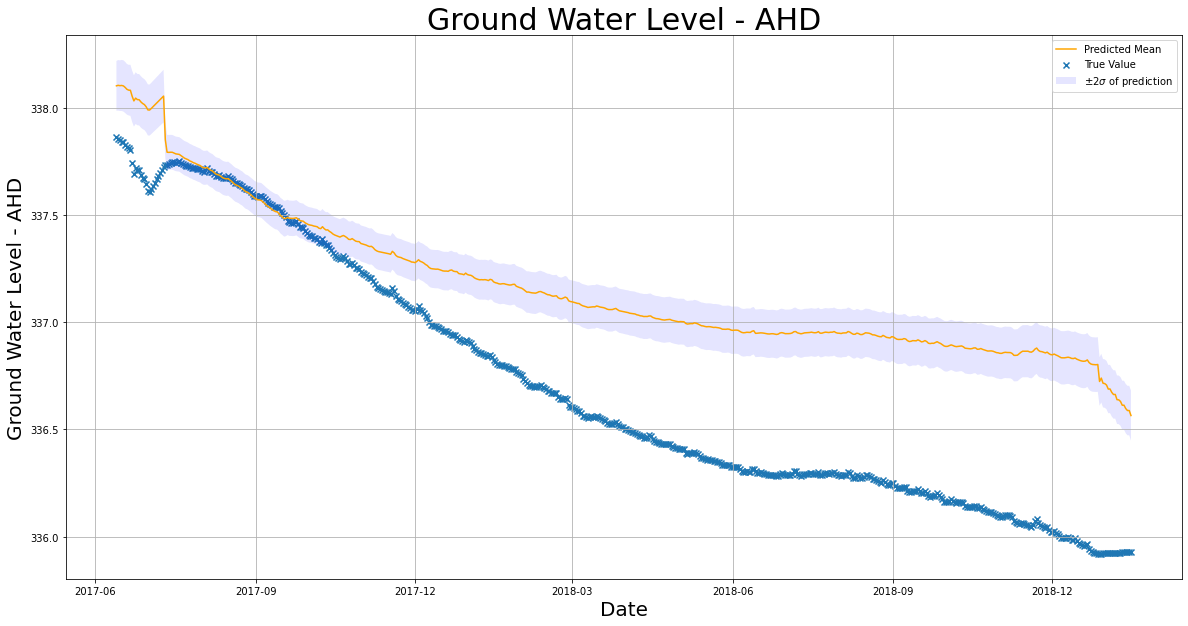

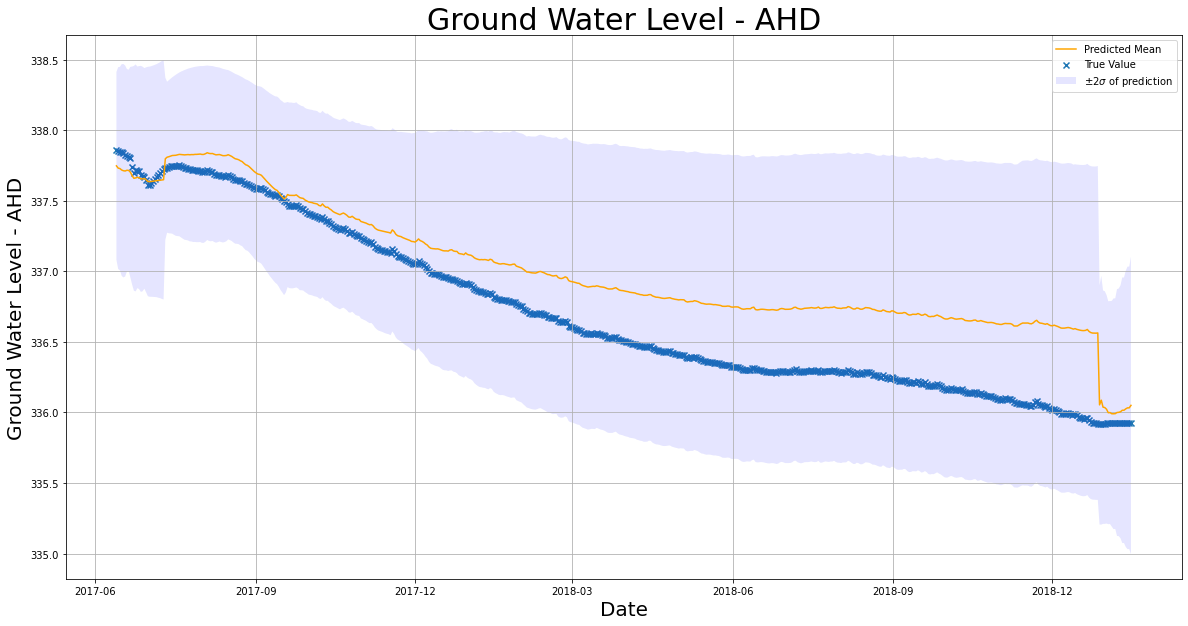

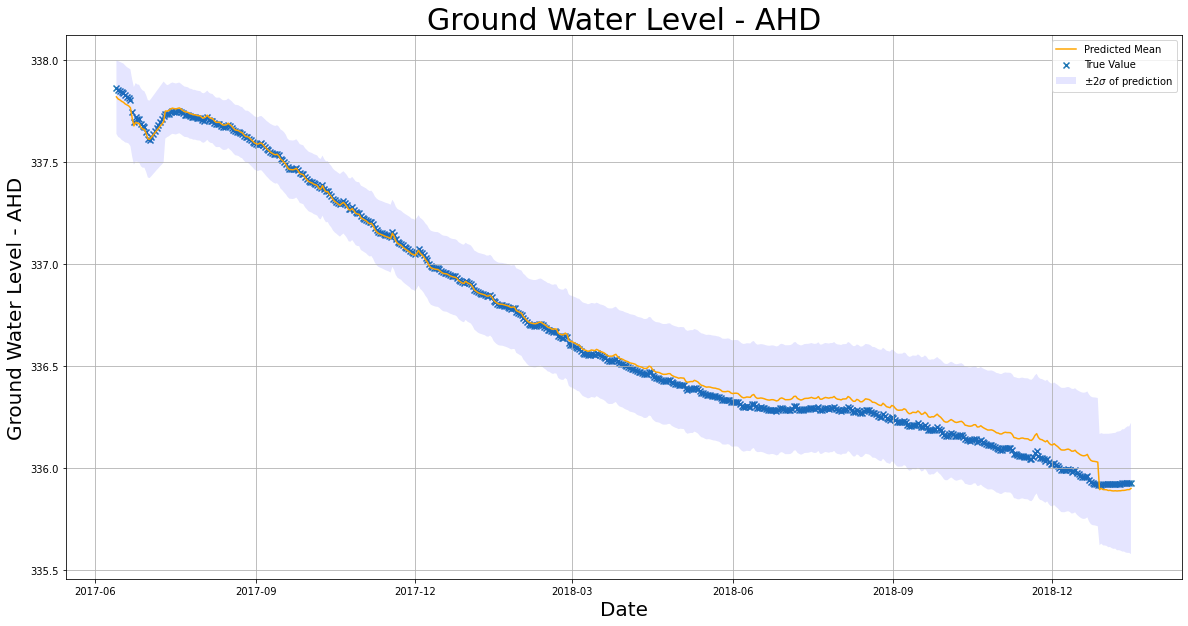

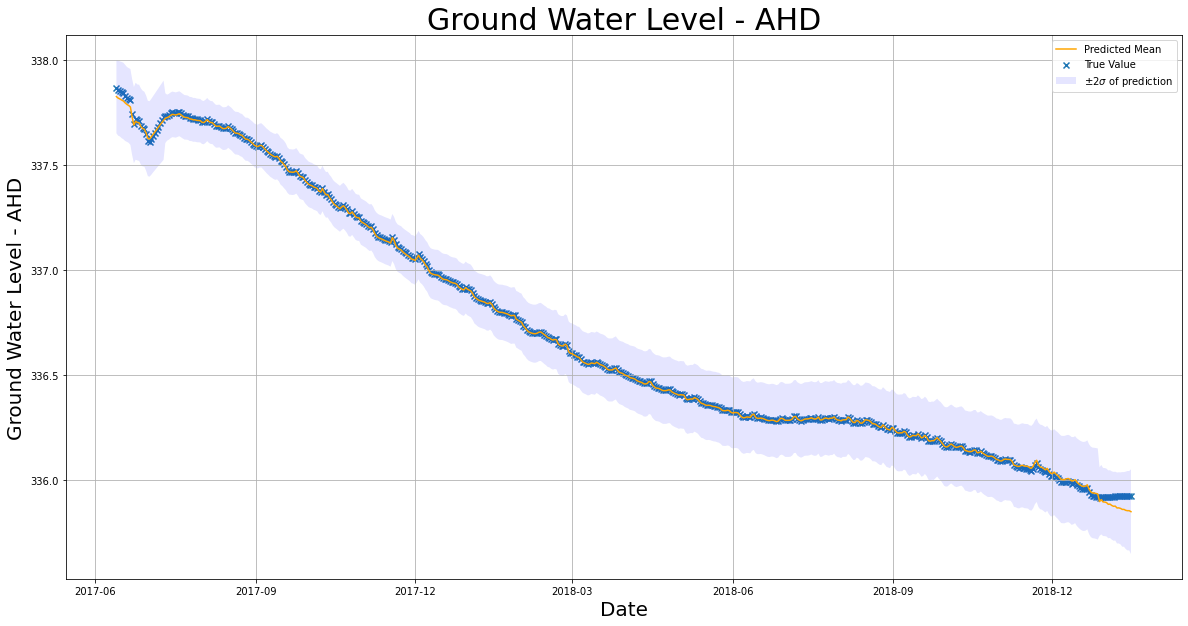

In [38]:
# split data
x_train569,x_test569,y_train569,y_test569 = data_split(data569,0.7)
print(f"Training set contains {y_train569.shape[0]} observations.")
print(f"Training set contains {y_test569.shape[0]} observations.")

# exact gp
fm1_569_losses, fm1_569 = model_train(x_train569,y_train569,
                                      FullGP,"Squared Exponential",
                                      n_iterations=200,learning_rate=0.1)
fm1_569_mae,fm1_569_rmse = gp_model_eval(x_train569,y_train569,fm1_569)
fm1_569_best_params = gp_optimal_params(fm1_569)
f_mean_fm1_569, f_var_fm1_569, f_mean_original_fm1_569,\
f_var_original_fm1_569, y_test_original_fm1_569, \
fig_fm1_569 = gp_pred(fm1_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

fm2_569_losses, fm2_569 = model_train(x_train569,y_train569,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 1/2)
fm2_569_mae,fm2_569_rmse = gp_model_eval(x_train569,y_train569,fm2_569)
fm2_569_best_params = gp_optimal_params(fm2_569)
f_mean_fm2_569, f_var_fm2_569, f_mean_original_fm2_569,\
f_var_original_fm2_569, y_test_original_fm2_569, \
fig_fm2_569 = gp_pred(fm2_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# Matern 3/2 kernel

fm3_569_losses, fm3_569 = model_train(x_train569,y_train569,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 3/2)
fm3_569_mae,fm3_569_rmse = gp_model_eval(x_train569,y_train569,fm3_569)
fm3_569_best_params = gp_optimal_params(fm3_569)
f_mean_fm3_569, f_var_fm3_569, f_mean_original_fm3_569,\
f_var_original_fm3_569, y_test_original_fm3_569, \
fig_fm3_569 = gp_pred(fm3_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# Matern 5/2 kernel

fm4_569_losses, fm4_569 = model_train(x_train569,y_train569,
                                      FullGP,"Matern",
                                      n_iterations=200,learning_rate=0.1,
                                     nu = 5/2)
fm4_569_mae,fm4_569_rmse = gp_model_eval(x_train569,y_train569,fm4_569)
fm4_569_best_params = gp_optimal_params(fm4_569)
f_mean_fm4_569, f_var_fm4_569, f_mean_original_fm4_569,\
f_var_original_fm4_569, y_test_original_fm4_569, \
fig_fm4_569 = gp_pred(fm4_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# variational approximate gp
# RBF kernel

va1_569,va1_569_likelihood,va1_569_train_loader,va1_569_test_loader = model_train(x_train569,y_train569,
                                      GPModel,cov_function_name = "Squared Exponential",
                                      n_iterations=200,learning_rate=0.1, x_test = x_test569,
                                      y_test = y_test569,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va1_569_mae,va1_569_rmse = vagp_model_eval(va1_569_train_loader,va1_569_train_loader,
                                           va1_569,va1_569_likelihood,y_train569)
va1_569_best_params = gp_optimal_params(va1_569)

f_mean_va1_569, f_var_va1_569, f_mean_original_va1_569,\
f_var_original_va1_569, y_test_original_va1_569, \
fig_va1_569 = gp_pred(va1_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# Matern 1/2 kernel

va2_569,va2_569_likelihood,va2_569_train_loader,va2_569_test_loader = model_train(x_train569,y_train569,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=1/2, x_test = x_test569,
                                      y_test = y_test569,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va2_569_mae,va2_569_rmse = vagp_model_eval(va2_569_train_loader,va2_569_train_loader,
                                           va2_569,va2_569_likelihood,y_train569)
va2_569_best_params = gp_optimal_params(va2_569)
f_mean_va2_569, f_var_va2_569, f_mean_original_va2_569,\
f_var_original_va2_569, y_test_original_va2_569, \
fig_va2_569 = gp_pred(va2_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# Matern 3/2 kernel

va3_569,va3_569_likelihood,va3_569_train_loader,va3_569_test_loader = model_train(x_train569,y_train569,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=3/2, x_test = x_test569,
                                      y_test = y_test569,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va3_569_mae,va3_569_rmse = vagp_model_eval(va3_569_train_loader,va3_569_train_loader,
                                           va3_569,va3_569_likelihood,y_train569)
va3_569_best_params = gp_optimal_params(va2_569)
f_mean_va3_569, f_var_va3_569, f_mean_original_va3_569,\
f_var_original_va3_569, y_test_original_va3_569, \
fig_va3_569 = gp_pred(va3_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

# Matern 5/2 kernel

va4_569,va4_569_likelihood,va4_569_train_loader,va4_569_test_loader = model_train(x_train569,y_train569,
                                      GPModel,cov_function_name = "Matern", n_iterations=200,
                                    learning_rate=0.1, nu=5/2, x_test = x_test569,
                                      y_test = y_test569,n_inducing_rate = 0.25, n_batch_rate = 0.85,
                                      num_epochs = 200)
va4_569_mae,va4_569_rmse = vagp_model_eval(va4_569_train_loader,va4_569_train_loader,
                                           va4_569,va4_569_likelihood,y_train569)
va4_569_best_params = gp_optimal_params(va4_569)
f_mean_va4_569, f_var_va4_569, f_mean_original_va4_569,\
f_var_original_va4_569, y_test_original_va4_569, \
fig_va4_569 = gp_pred(va4_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)

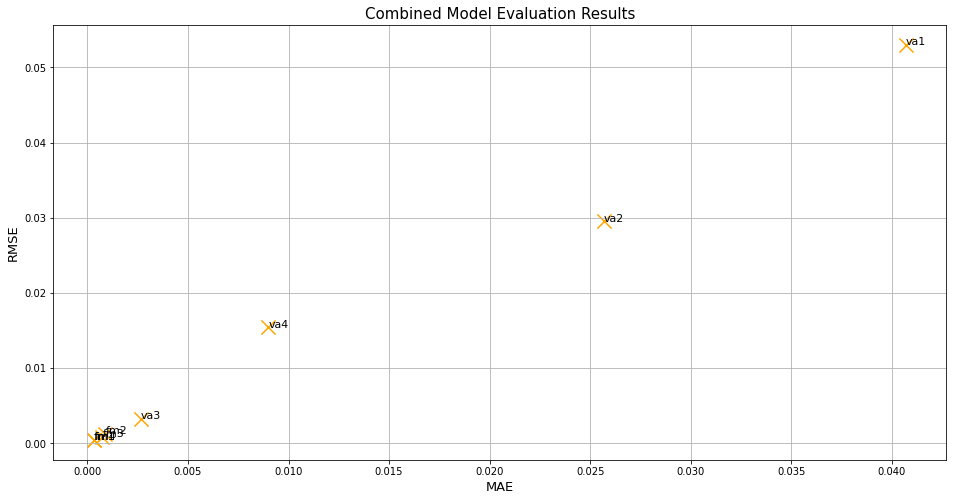

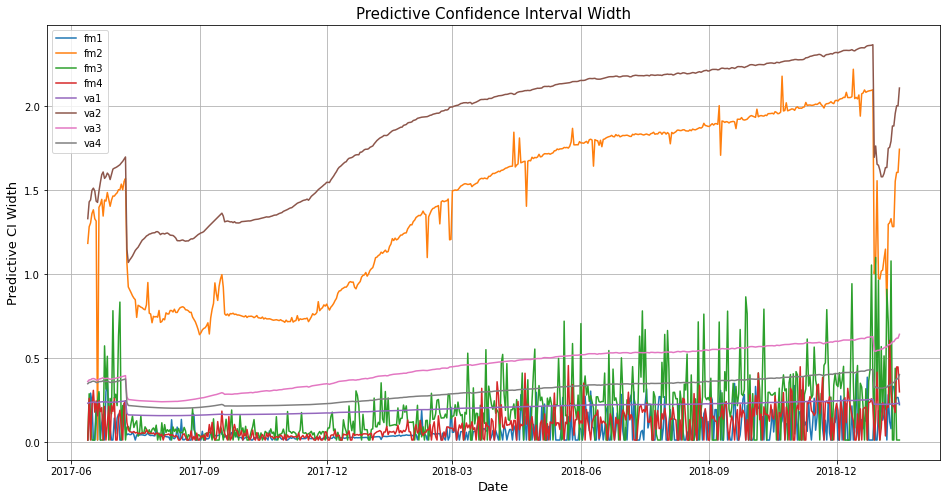

In [39]:
# metrics comparison
eval_results_569 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
              "MAE_569":[fm1_569_mae,fm2_569_mae,fm3_569_mae,fm4_569_mae,
                         va1_569_mae,va2_569_mae,va3_569_mae,va4_569_mae],
             "RMSE_569":[fm1_569_rmse,fm2_569_rmse,fm3_569_rmse,fm4_569_rmse,
                         va1_569_rmse,va2_569_rmse,va3_569_rmse,va4_569_rmse
                       ]})
eval_results_plot(eval_results_569)

# CI width
CIwidth_569 = pd.DataFrame({"Model":["fm1","fm2","fm3","fm4",
                         "va1","va2","va3","va4"],
                           "CI Width":[4*np.sqrt(f_var_original_fm1_569),4*np.sqrt(f_var_original_fm2_569),
                                      4*np.sqrt(f_var_original_fm3_569),4*np.sqrt(f_var_original_fm4_569),
                                      4*np.sqrt(f_var_original_va1_569),4*np.sqrt(f_var_original_va2_569),
                                      4*np.sqrt(f_var_original_va3_569),4*np.sqrt(f_var_original_va4_569)]})
CIwidth_plot(CIwidth_569,data569,x_train569)



 /Users/yiyima/opt/anaconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning:Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.


RMSE of the test data: 0.0032624933
MAE of the test data: 0.0025294665


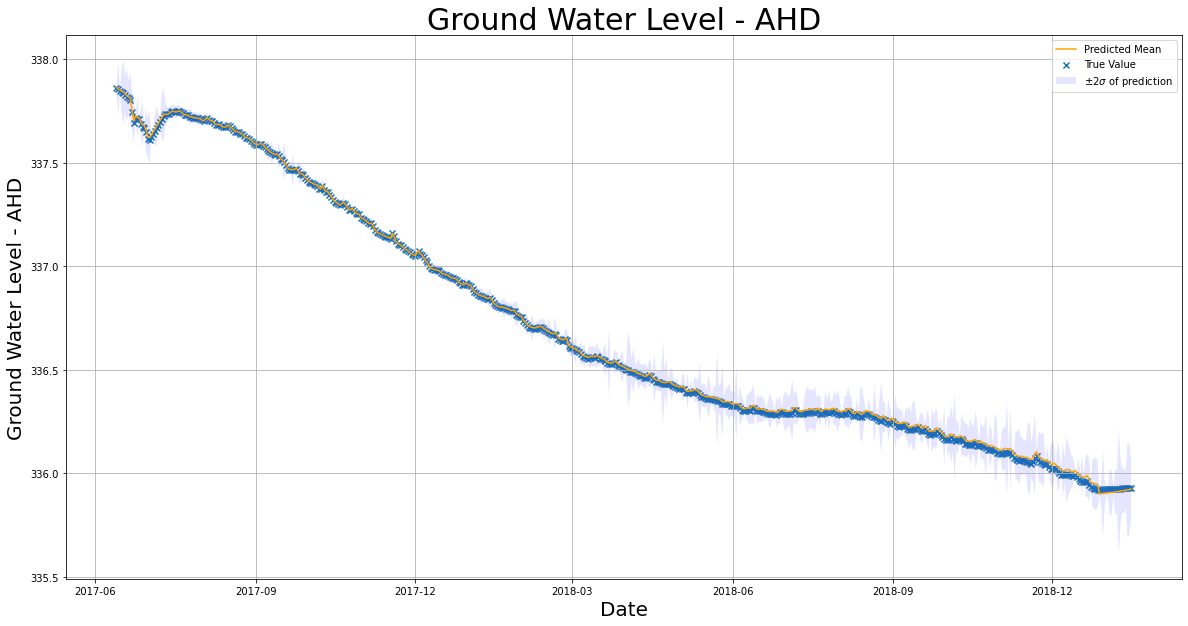

In [41]:
# choose fm4 according to all conditions
fig_fm4_569 = gp_pred(fm4_569,x_train569,x_test569,\
                      y_test569,data569,min_max_diff=3.347,\
                      min_ = 335.26,plot=True)
fm4_569_mae_test,fm4_569_rmse_test = gp_model_eval(x_test569,y_test569,fm4_569)
print("RMSE of the test data:", fm4_569_rmse_test)
print("MAE of the test data:", fm4_569_mae_test)

### Record the residuals

In [42]:
date = pd.date_range(start = data334["date"][x_train334.shape[0]], end = data334["date"].iloc[-1])
res = (f_mean_original_fm4_334-y_test_original_fm4_334.detach().numpy())
df_res = pd.DataFrame({"Date":date,"residual":res,"fitted":f_mean_fm4_334})
df_res = df_res.set_index('Date')
df_res.to_csv('fm4_334_res.csv')

In [43]:
date = pd.date_range(start = data976["date"][x_train976.shape[0]], end = data976["date"].iloc[-1])
res = (f_mean_original_fm4_976-y_test_original_fm4_976.detach().numpy())
df_res = pd.DataFrame({"Date":date,"residual":res,"fitted":f_mean_fm4_976})
df_res = df_res.set_index('Date')
df_res.to_csv('fm4_976_res.csv')

In [44]:
date = pd.date_range(start = data067["date"][x_train067.shape[0]], end = data067["date"].iloc[-1])
res = (f_mean_original_fm4_067-y_test_original_fm4_067.detach().numpy())
df_res = pd.DataFrame({"Date":date,"residual":res,"fitted":f_mean_fm4_067})
df_res = df_res.set_index('Date')
df_res.to_csv('fm4_067_res.csv')

In [45]:
date = pd.date_range(start = data569["date"][x_train569.shape[0]], end = data569["date"].iloc[-1])
res = (f_mean_original_fm4_569-y_test_original_fm4_569.detach().numpy())
df_res = pd.DataFrame({"Date":date,"residual":res,"fitted":f_mean_fm4_569})
df_res = df_res.set_index('Date')
df_res.to_csv('fm4_569_res.csv')